In [4]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'E:/Raw data/PTT'
totalboard_name = 'BG-CC-MV-SX-TJ-WT'
board_name = ['Boy-Girl','C_Chat','movie','sex','Tech_job','WomenTalk']
board_dict_index = {'Boy-Girl':0,'C_Chat':1,'movie':2,'sex':3,'Tech_job':4,'WomenTalk':5}

build_vocab = True
label_newnum = len(board_name)
max_word_length = 250+2
min_word_length = 100
max_push_length = 100+2
words_limit = 30000
filters_char='"#()*-/;[\]^_`{|}~\t\n'
#filters_char='ˊˋ#*×/\\^_`|＼﹨｜〝〞‵′＊／－-≦≧＿＃⌒‿．§◎˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔'

SOS_id = '<sos>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
new_push_dir = []
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])
    new_push_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_push'))
    if not os.path.exists(new_push_dir[name_ind]):
        os.makedirs(new_push_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import jieba
import json

# Import dictionary fron jieba and PTT.
jieba.set_dictionary('C:/Users/User/Anaconda3/Lib/site-packages/jieba/dict.txt.big')
jieba.load_userdict('C:/Users/User/Anaconda3/Lib/site-packages/jieba/userdict.txt')

text_content = []
text_push = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    push_length = int(dfs_total.iloc[dfs_index, 6])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character for content.
    text = SOS_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row
        else:
            text = text + ' ' + EOS_id
    
    # Add start and end character for push.
    with open(os.path.join(new_push_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            # Read content and remove empty.
            for row in rows:
                # load only the first push text.
                push = SOS_id + ' ' + row + ' ' + EOS_id
                text_push.append(push)
    text_content.append(text)
    
if build_vocab:
    from keras.preprocessing.text import Tokenizer
    # Build vocabulary and convert content to sequence by Keras tool.
    tokenizer = Tokenizer(num_words=words_limit, 
                          filters=filters_char,
                          lower=True,
                          split=" ")
                          #oov_token=UNK_word)
    tokenizer.fit_on_texts(text_content+text_push)
    vocab_sort = tokenizer.word_index
    vocab_counts = tokenizer.word_counts
    vocab_docs = tokenizer.word_docs

    print('Vocabulary size:', len(vocab_sort))
    vocab = {}
    vocab_reverse = {}
    vocab_keys = list(vocab_sort.keys())
    for vocab_word in vocab_keys:
        vocab_index = vocab_sort[vocab_word]
        if vocab_index <= words_limit+2:
            vocab_reverse[vocab_index] = vocab_keys[vocab_index-1]
            vocab[vocab_keys[vocab_index-1]] = vocab_index
            if vocab_index % 1000 == 0 or vocab_index < 100:
                print(vocab[vocab_word], vocab_word, vocab_reverse[vocab_index], 
                      vocab_counts[vocab_word], vocab_docs[vocab_word])
    else:
        #vocab[SOS_id] = words_limit + 1
        #vocab_reverse[words_limit + 1] = SOS_id
        #vocab[EOS_id] = words_limit + 2
        #vocab_reverse[words_limit + 2] = EOS_id
        vocab[UNK_id] = words_limit + 3
        vocab_reverse[words_limit + 3] = UNK_id

    # Save vocabulary information.
    with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_sort))
    with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_counts))
    with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_docs))
    with open(os.path.join(totalboard_dir, 'vocab.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab))
    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_reverse))
else:
    # Load vocabulary information.
    with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_reverse = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_sort = eval(f_text.read())
    #with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'r', encoding='utf-8-sig') as f_text:
        #vocab_counts = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_docs = eval(f_text.read())
    vocab_size = len(vocab)

    # Build vocabulary and convert content to sequence by Keras tool.
    # Convert texts list to sequences list.
    def texts_to_sequences(text_list):
        sequences_list = []
        for text in text_list:
            words = text.split(' ')
            sequence = []
            for word in words:
                if filters_char.find(word)>=0:
                    continue
                elif word in vocab:
                    sequence.append(vocab[word])
                else:
                    sequence.append(vocab[UNK_id])
            sequences_list.append(sequence)
        return sequences_list

# 將單字轉換成字庫的索引值
if build_vocab:
    total_content_word_ids = tokenizer.texts_to_sequences(text_content+text_push)
else:
    total_content_word_ids = texts_to_sequences(text_content+text_push)
total_content_size = [len(word_ids) for word_ids in total_content_word_ids]

Building prefix dict from C:\Users\User\Anaconda3\Lib\site-packages\jieba\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.ufa6ae29b0cbce8b45e006c7fa30eaaf8.cache
Loading model cost 0.973 seconds.
Prefix dict has been built succesfully.


Vocabulary size: 441035
1 <sos> <sos> 1506497 1506497
2 <eos> <eos> 1506497 1506497
3 . . 908712 271897
4 的 的 800583 504881
5 , , 703008 348633
6 是 是 366564 293198
7 我 我 349251 259420
8 了 了 309852 259993
9 ' ' 239430 103912
10 你 你 222123 175475
11 ? ? 220762 176965
12 有 有 218561 182774
13 就 就 207726 182331
14 都 都 199092 174859
15 也 也 174970 153132
16 不 不 158586 139858
17 在 在 137875 116890
18 很 很 130847 115145
19 會 會 127763 112276
20 ! ! 117123 97417
21 嗎 嗎 116168 108201
22 好 好 108314 100447
23 要 要 107149 96017
24 看 看 105601 92116
25 跟 跟 104109 92794
26 吧 吧 95152 92702
27 啊 啊 94385 89339
28 他 他 93530 69971
29 說 說 90190 79056
30 人 人 87441 77070
31 可以 可以 84679 77742
32 沒 沒 83049 77180
33 覺得 覺得 76649 70244
34 去 去 74636 66957
35 想 想 70038 63091
36 被 被 66612 60129
37 真的 真的 66543 62525
38 自己 自己 63738 55446
39 什麼 什麼 62803 57320
40 不是 不是 61690 58887
41 就是 就是 60328 56400
42 她 她 59368 41182
43 但 但 59357 54388
44 到 到 57011 52855
45 知道 知道 53027 48341
46 還是 還是 50558 47137
47 不會 不會 49926 47556
48 沒有 

In [5]:
print('Vocabulary size: ', len(vocab))

skip_window = 2 # How many words to consider left and right.
num_skips = 2*skip_window # How many times to reuse an input to generate a context.
sample_threshold = 0.0002

sum_content_size = sum(total_content_size)
print('Sum over all context size: ',sum_content_size)

# Set sampling rate for word using frequency.
def sampling_rate(sample_num, total_num, sample_threshold):
    z_rate = sample_num/total_num/sample_threshold
    return min((np.sqrt(z_rate) + 1.0)/z_rate, 1.0)

sum_vocab_counts = 0
unk_count = 0
for vocab_word in vocab_sort:
    vocab_index = vocab_sort[vocab_word]
    sum_vocab_counts += vocab_counts[vocab_word]
    if vocab_index > words_limit+2:
        unk_count += vocab_counts[vocab_word]
print('Sum over all vocabulary counts: ',sum_vocab_counts)

# Build sampling rate dict for vocabulary.
vocab_rate = {}
for vocab_word in vocab:
    vocab_index = vocab[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_rate[vocab_index] = sampling_rate(vocab_counts[vocab_word], 
                                        sum_vocab_counts, sample_threshold)
    else:
        assert vocab_word == UNK_id
        vocab_rate[vocab_index] = sampling_rate(unk_count, 
                             sum_vocab_counts, sample_threshold)
        break

# Convert text content to context inputs and labels array.
def generate_ngram(content_ids, content_size, skip_window):
    inputs = np.ndarray(shape=(content_size), dtype=np.int32)
    labels = np.ndarray(shape=(content_size, skip_window*2), dtype=np.int32)
    for i in range(content_size):
        for j in range(skip_window):
            if i-j>0:
                labels[i, j*2] = content_ids[i-j-1]
            else:
                labels[i, j*2] = vocab[SOS_id]
            if i+j<content_size-1:
                labels[i, j*2+1] = content_ids[i+j+1]
            else:
                labels[i, j*2+1] = vocab[EOS_id]
    return content_ids, labels

# Build all of context inputs and labels by array.
total_inputs = np.ndarray(shape=(sum_content_size), dtype=np.int32)
total_labels = np.ndarray(shape=(sum_content_size, skip_window*2), dtype=np.int32)
context_index = 0
for word_ids, word_size in zip(total_content_word_ids, total_content_size):
    inputs, labels = generate_ngram(word_ids, word_size, skip_window)
    total_inputs[context_index:context_index+word_size] = inputs
    total_labels[context_index:context_index+word_size,:] = labels
    context_index += word_size
else:
    assert context_index == sum_content_size

# If the word id was out of vocabulary, reset id to UNK_id.
np.minimum(total_inputs, words_limit + 3, total_inputs)
np.minimum(total_labels, words_limit + 3, total_labels)

Vocabulary size:  30003
Sum over all context size:  23488233
Sum over all vocabulary counts:  24962176


array([[   1,    3,    1,   92],
       [   1,   92,    1, 3394],
       [   3, 3394,    1, 3279],
       ...,
       [   8,  130,  594,    2],
       [  21,    2,    8,    2],
       [ 130,    2,   21,    2]])

INFO:tensorflow:Restoring parameters from E:/Raw data/PTT\model\PTT_Words_Embedding_1526955724.200002\model-60
Embeddings lookup shape:  (30004, 300)

epoch1
Iteration  10378  ( 10.0 %) Train mean loss:  0.17979367  ( std:  0.34360388 ) ; run time:  30 [s]
Iteration  20749  ( 20.0 %) Train mean loss:  0.1050929  ( std:  0.25457135 ) ; run time:  61 [s]
Iteration  31114  ( 30.0 %) Train mean loss:  0.0756844  ( std:  0.21209155 ) ; run time:  91 [s]
Iteration  41486  ( 40.0 %) Train mean loss:  0.059675533  ( std:  0.18578866 ) ; run time:  121 [s]
Iteration  51860  ( 50.0 %) Train mean loss:  0.049494427  ( std:  0.16742963 ) ; run time:  151 [s]
Iteration  62220  ( 60.0 %) Train mean loss:  0.042444568  ( std:  0.15367778 ) ; run time:  180 [s]
Iteration  72596  ( 70.0 %) Train mean loss:  0.037228346  ( std:  0.14285074 ) ; run time:  210 [s]
Iteration  82960  ( 80.0 %) Train mean loss:  0.03320916  ( std:  0.13405699 ) ; run time:  240 [s]
Iteration  93334  ( 90.0 %) Train mean loss

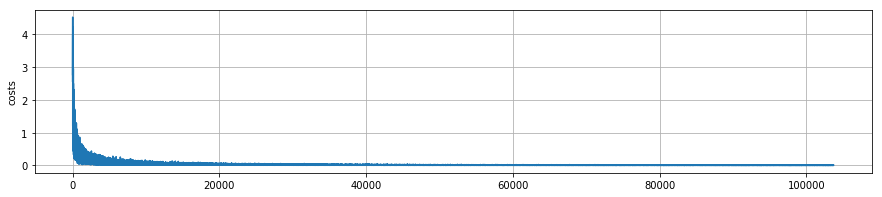


epoch2
Iteration  10366  ( 10.0 %) Train mean loss:  0.0035480177  ( std:  0.00213239 ) ; run time:  29 [s]
Iteration  20736  ( 20.0 %) Train mean loss:  0.003378234  ( std:  0.0020355491 ) ; run time:  59 [s]
Iteration  31109  ( 30.0 %) Train mean loss:  0.0032395432  ( std:  0.0019567779 ) ; run time:  89 [s]
Iteration  41476  ( 40.0 %) Train mean loss:  0.0031180487  ( std:  0.0018906365 ) ; run time:  119 [s]
Iteration  51845  ( 50.0 %) Train mean loss:  0.0030042774  ( std:  0.0018384155 ) ; run time:  148 [s]
Iteration  62220  ( 60.0 %) Train mean loss:  0.0029042936  ( std:  0.0017902829 ) ; run time:  178 [s]
Iteration  72591  ( 70.0 %) Train mean loss:  0.0028093716  ( std:  0.0017476782 ) ; run time:  207 [s]
Iteration  82954  ( 80.0 %) Train mean loss:  0.0027250072  ( std:  0.001708951 ) ; run time:  237 [s]
Iteration  93330  ( 90.0 %) Train mean loss:  0.0026466222  ( std:  0.001675102 ) ; run time:  267 [s]
Iteration  103700  ( 100.0 %) Train mean loss:  0.0025705486  ( 

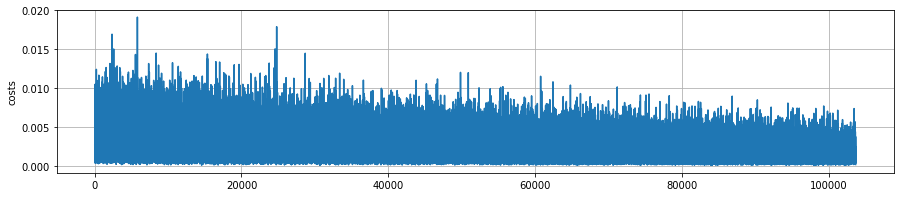


epoch3
Iteration  10381  ( 10.0 %) Train mean loss:  0.0017874528  ( std:  0.0010585006 ) ; run time:  29 [s]
Iteration  20757  ( 20.0 %) Train mean loss:  0.0017458848  ( std:  0.0010356619 ) ; run time:  59 [s]
Iteration  31126  ( 30.0 %) Train mean loss:  0.0017056428  ( std:  0.0010146855 ) ; run time:  89 [s]
Iteration  41496  ( 40.0 %) Train mean loss:  0.0016691746  ( std:  0.0009922785 ) ; run time:  119 [s]
Iteration  51863  ( 50.0 %) Train mean loss:  0.0016337472  ( std:  0.00097578927 ) ; run time:  149 [s]
Iteration  62228  ( 60.0 %) Train mean loss:  0.0015982375  ( std:  0.0009561167 ) ; run time:  179 [s]
Iteration  72589  ( 70.0 %) Train mean loss:  0.0015677189  ( std:  0.00094245444 ) ; run time:  208 [s]
Iteration  82962  ( 80.0 %) Train mean loss:  0.0015380277  ( std:  0.0009283641 ) ; run time:  238 [s]
Iteration  93332  ( 90.0 %) Train mean loss:  0.0015101698  ( std:  0.0009152195 ) ; run time:  267 [s]
Iteration  103701  ( 100.0 %) Train mean loss:  0.0014820

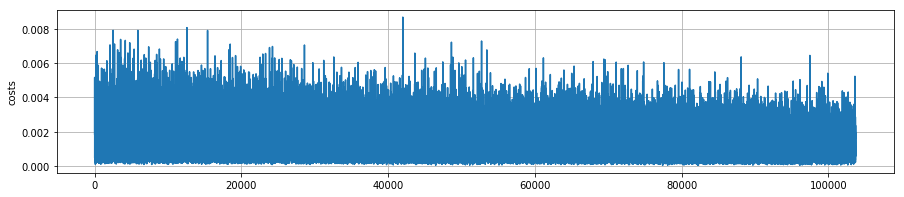


epoch4
Iteration  10373  ( 10.0 %) Train mean loss:  0.001193906  ( std:  0.0007083519 ) ; run time:  29 [s]
Iteration  20745  ( 20.0 %) Train mean loss:  0.0011724642  ( std:  0.0006942634 ) ; run time:  58 [s]
Iteration  31115  ( 30.0 %) Train mean loss:  0.0011590492  ( std:  0.0006835382 ) ; run time:  88 [s]
Iteration  41487  ( 40.0 %) Train mean loss:  0.0011404888  ( std:  0.0006716352 ) ; run time:  117 [s]
Iteration  51851  ( 50.0 %) Train mean loss:  0.0011246674  ( std:  0.00066378264 ) ; run time:  146 [s]
Iteration  62224  ( 60.0 %) Train mean loss:  0.0011081115  ( std:  0.0006549935 ) ; run time:  176 [s]
Iteration  72593  ( 70.0 %) Train mean loss:  0.001092929  ( std:  0.00064775825 ) ; run time:  205 [s]
Iteration  82968  ( 80.0 %) Train mean loss:  0.0010769423  ( std:  0.0006409204 ) ; run time:  235 [s]
Iteration  93345  ( 90.0 %) Train mean loss:  0.001061357  ( std:  0.00063268543 ) ; run time:  264 [s]
Iteration  103706  ( 100.0 %) Train mean loss:  0.001047224

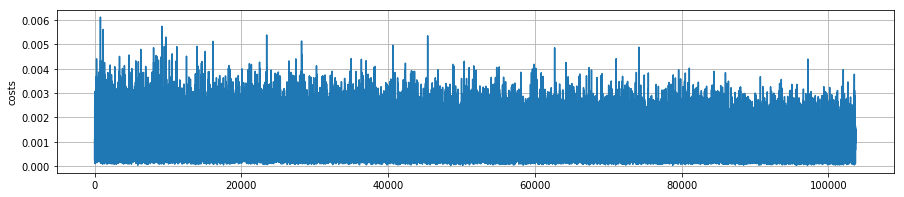


epoch5
Iteration  10368  ( 10.0 %) Train mean loss:  0.0009119802  ( std:  0.0005272672 ) ; run time:  29 [s]
Iteration  20742  ( 20.0 %) Train mean loss:  0.00089961936  ( std:  0.0005247931 ) ; run time:  59 [s]
Iteration  31113  ( 30.0 %) Train mean loss:  0.00088455144  ( std:  0.00051715603 ) ; run time:  89 [s]
Iteration  41484  ( 40.0 %) Train mean loss:  0.00087372394  ( std:  0.00051268196 ) ; run time:  118 [s]
Iteration  51860  ( 50.0 %) Train mean loss:  0.000861711  ( std:  0.0005060368 ) ; run time:  148 [s]
Iteration  62224  ( 60.0 %) Train mean loss:  0.0008513206  ( std:  0.00050061644 ) ; run time:  178 [s]
Iteration  72596  ( 70.0 %) Train mean loss:  0.000841762  ( std:  0.00049541524 ) ; run time:  207 [s]
Iteration  82963  ( 80.0 %) Train mean loss:  0.00083252444  ( std:  0.00049153366 ) ; run time:  237 [s]
Iteration  93326  ( 90.0 %) Train mean loss:  0.00082291046  ( std:  0.00048709832 ) ; run time:  267 [s]
Iteration  103711  ( 100.0 %) Train mean loss:  0.

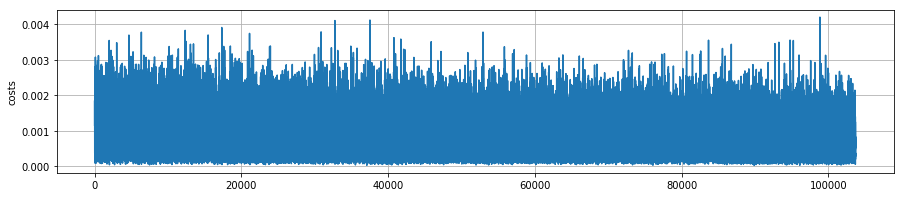


epoch6
Iteration  10368  ( 10.0 %) Train mean loss:  0.00071720826  ( std:  0.0004200055 ) ; run time:  29 [s]
Iteration  20739  ( 20.0 %) Train mean loss:  0.00071290875  ( std:  0.00042031432 ) ; run time:  59 [s]
Iteration  31115  ( 30.0 %) Train mean loss:  0.00070703053  ( std:  0.00041716633 ) ; run time:  89 [s]
Iteration  41483  ( 40.0 %) Train mean loss:  0.0006998742  ( std:  0.000412619 ) ; run time:  118 [s]
Iteration  51856  ( 50.0 %) Train mean loss:  0.00069215917  ( std:  0.00040895445 ) ; run time:  148 [s]
Iteration  62234  ( 60.0 %) Train mean loss:  0.0006854776  ( std:  0.0004052021 ) ; run time:  178 [s]
Iteration  72615  ( 70.0 %) Train mean loss:  0.00067899365  ( std:  0.0004016807 ) ; run time:  208 [s]
Iteration  82980  ( 80.0 %) Train mean loss:  0.00067274005  ( std:  0.00039834713 ) ; run time:  237 [s]
Iteration  93350  ( 90.0 %) Train mean loss:  0.0006670341  ( std:  0.00039502006 ) ; run time:  267 [s]
Iteration  103712  ( 100.0 %) Train mean loss:  0

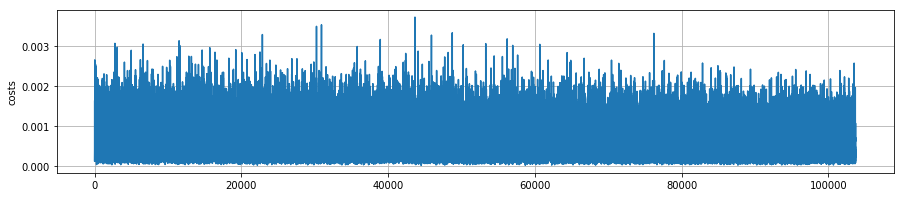


epoch7
Iteration  10370  ( 10.0 %) Train mean loss:  0.00060684263  ( std:  0.0003524008 ) ; run time:  29 [s]
Iteration  20735  ( 20.0 %) Train mean loss:  0.0005979022  ( std:  0.00034873647 ) ; run time:  59 [s]
Iteration  31105  ( 30.0 %) Train mean loss:  0.0005916357  ( std:  0.00034646541 ) ; run time:  89 [s]
Iteration  41468  ( 40.0 %) Train mean loss:  0.00058772316  ( std:  0.00034529972 ) ; run time:  119 [s]
Iteration  51833  ( 50.0 %) Train mean loss:  0.0005828737  ( std:  0.00034259487 ) ; run time:  148 [s]
Iteration  62209  ( 60.0 %) Train mean loss:  0.0005785915  ( std:  0.00034029232 ) ; run time:  178 [s]
Iteration  72581  ( 70.0 %) Train mean loss:  0.0005744349  ( std:  0.00033814416 ) ; run time:  208 [s]
Iteration  82944  ( 80.0 %) Train mean loss:  0.0005700323  ( std:  0.00033579633 ) ; run time:  237 [s]
Iteration  93318  ( 90.0 %) Train mean loss:  0.0005655813  ( std:  0.00033332373 ) ; run time:  267 [s]
Iteration  103691  ( 100.0 %) Train mean loss:  0

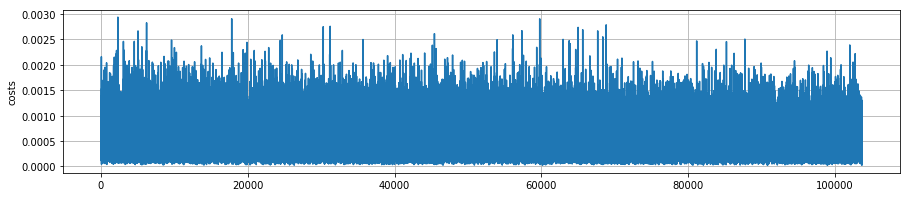


epoch8
Iteration  10370  ( 10.0 %) Train mean loss:  0.0005147912  ( std:  0.00030347836 ) ; run time:  29 [s]
Iteration  20742  ( 20.0 %) Train mean loss:  0.0005125941  ( std:  0.00030011474 ) ; run time:  59 [s]
Iteration  31111  ( 30.0 %) Train mean loss:  0.00050877314  ( std:  0.00029866936 ) ; run time:  89 [s]
Iteration  41482  ( 40.0 %) Train mean loss:  0.00050457823  ( std:  0.00029628858 ) ; run time:  118 [s]
Iteration  51848  ( 50.0 %) Train mean loss:  0.000500365  ( std:  0.00029397575 ) ; run time:  148 [s]
Iteration  62230  ( 60.0 %) Train mean loss:  0.00049832213  ( std:  0.00029248 ) ; run time:  178 [s]
Iteration  72597  ( 70.0 %) Train mean loss:  0.0004951049  ( std:  0.0002910153 ) ; run time:  208 [s]
Iteration  82967  ( 80.0 %) Train mean loss:  0.00049211644  ( std:  0.000289222 ) ; run time:  238 [s]
Iteration  93337  ( 90.0 %) Train mean loss:  0.0004887719  ( std:  0.00028731787 ) ; run time:  267 [s]
Iteration  103715  ( 100.0 %) Train mean loss:  0.000

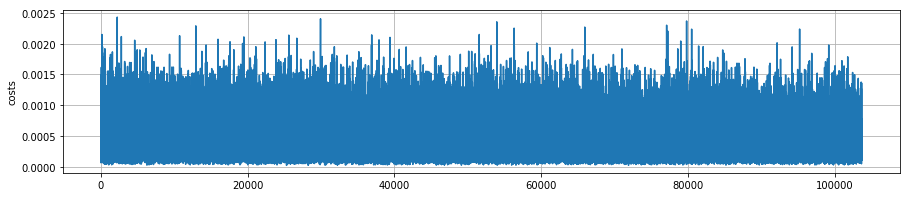


epoch9
Iteration  10369  ( 10.0 %) Train mean loss:  0.00045498455  ( std:  0.00026640706 ) ; run time:  29 [s]
Iteration  20737  ( 20.0 %) Train mean loss:  0.00045020247  ( std:  0.0002630238 ) ; run time:  59 [s]
Iteration  31118  ( 30.0 %) Train mean loss:  0.000447515  ( std:  0.0002619892 ) ; run time:  89 [s]
Iteration  41480  ( 40.0 %) Train mean loss:  0.00044459442  ( std:  0.00026033077 ) ; run time:  119 [s]
Iteration  51844  ( 50.0 %) Train mean loss:  0.0004420083  ( std:  0.00025892357 ) ; run time:  148 [s]
Iteration  62217  ( 60.0 %) Train mean loss:  0.0004388666  ( std:  0.00025706372 ) ; run time:  178 [s]
Iteration  72595  ( 70.0 %) Train mean loss:  0.0004358532  ( std:  0.00025599627 ) ; run time:  208 [s]
Iteration  82972  ( 80.0 %) Train mean loss:  0.00043391713  ( std:  0.00025457816 ) ; run time:  237 [s]
Iteration  93338  ( 90.0 %) Train mean loss:  0.00043156324  ( std:  0.00025307783 ) ; run time:  267 [s]
Iteration  103715  ( 100.0 %) Train mean loss:  

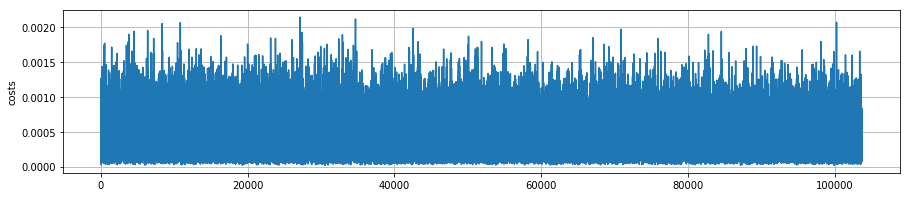


epoch10
Iteration  10373  ( 10.0 %) Train mean loss:  0.00040088763  ( std:  0.0002342897 ) ; run time:  29 [s]
Iteration  20751  ( 20.0 %) Train mean loss:  0.0003984013  ( std:  0.00023208474 ) ; run time:  59 [s]
Iteration  31134  ( 30.0 %) Train mean loss:  0.0003953398  ( std:  0.0002316638 ) ; run time:  89 [s]
Iteration  41499  ( 40.0 %) Train mean loss:  0.00039451267  ( std:  0.00023153229 ) ; run time:  118 [s]
Iteration  51862  ( 50.0 %) Train mean loss:  0.00039187996  ( std:  0.00023004267 ) ; run time:  148 [s]
Iteration  62233  ( 60.0 %) Train mean loss:  0.0003901093  ( std:  0.00022903521 ) ; run time:  177 [s]
Iteration  72610  ( 70.0 %) Train mean loss:  0.0003882738  ( std:  0.00022820546 ) ; run time:  207 [s]
Iteration  82979  ( 80.0 %) Train mean loss:  0.0003867068  ( std:  0.00022725092 ) ; run time:  236 [s]
Iteration  93344  ( 90.0 %) Train mean loss:  0.00038479868  ( std:  0.00022621271 ) ; run time:  266 [s]
Iteration  103705  ( 100.0 %) Train mean loss: 

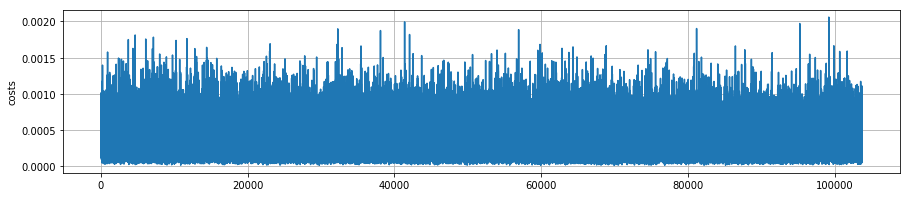


epoch11
Iteration  10368  ( 10.0 %) Train mean loss:  0.00036336234  ( std:  0.00021453762 ) ; run time:  29 [s]
Iteration  20744  ( 20.0 %) Train mean loss:  0.00036213783  ( std:  0.00021218369 ) ; run time:  59 [s]
Iteration  31117  ( 30.0 %) Train mean loss:  0.00036032003  ( std:  0.00021101118 ) ; run time:  88 [s]
Iteration  41492  ( 40.0 %) Train mean loss:  0.00035812022  ( std:  0.00020961756 ) ; run time:  118 [s]
Iteration  51859  ( 50.0 %) Train mean loss:  0.0003559592  ( std:  0.00020798975 ) ; run time:  148 [s]
Iteration  62228  ( 60.0 %) Train mean loss:  0.0003539154  ( std:  0.00020678784 ) ; run time:  177 [s]
Iteration  72601  ( 70.0 %) Train mean loss:  0.00035235882  ( std:  0.00020618511 ) ; run time:  207 [s]
Iteration  82963  ( 80.0 %) Train mean loss:  0.0003505775  ( std:  0.0002054436 ) ; run time:  237 [s]
Iteration  93323  ( 90.0 %) Train mean loss:  0.00034880798  ( std:  0.00020458011 ) ; run time:  266 [s]
Iteration  103700  ( 100.0 %) Train mean los

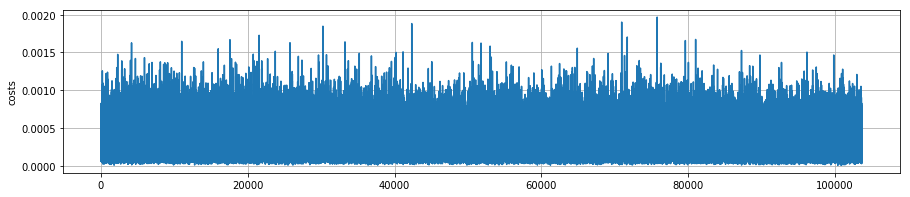


epoch12
Iteration  10381  ( 10.0 %) Train mean loss:  0.00032779478  ( std:  0.00018950613 ) ; run time:  29 [s]
Iteration  20749  ( 20.0 %) Train mean loss:  0.00032578548  ( std:  0.00018921794 ) ; run time:  59 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  0.0003251585  ( std:  0.00018940357 ) ; run time:  89 [s]
Iteration  41488  ( 40.0 %) Train mean loss:  0.00032395343  ( std:  0.0001882603 ) ; run time:  118 [s]
Iteration  51858  ( 50.0 %) Train mean loss:  0.00032291267  ( std:  0.00018780977 ) ; run time:  148 [s]
Iteration  62234  ( 60.0 %) Train mean loss:  0.00032161459  ( std:  0.0001871842 ) ; run time:  177 [s]
Iteration  72604  ( 70.0 %) Train mean loss:  0.00032062005  ( std:  0.00018714384 ) ; run time:  207 [s]
Iteration  82974  ( 80.0 %) Train mean loss:  0.0003191996  ( std:  0.00018607461 ) ; run time:  235 [s]
Iteration  93348  ( 90.0 %) Train mean loss:  0.00031776982  ( std:  0.00018520588 ) ; run time:  262 [s]
Iteration  103714  ( 100.0 %) Train mean los

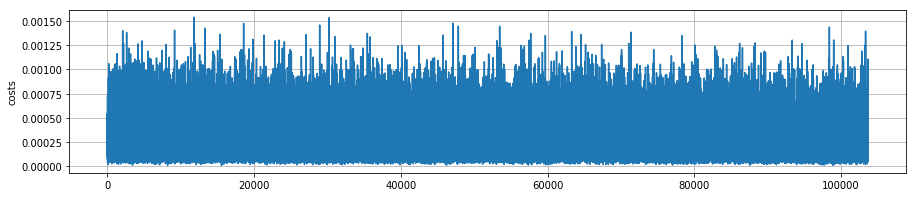


epoch13
Iteration  10368  ( 10.0 %) Train mean loss:  0.000301263  ( std:  0.0001774941 ) ; run time:  29 [s]
Iteration  20745  ( 20.0 %) Train mean loss:  0.00029995173  ( std:  0.00017659261 ) ; run time:  58 [s]
Iteration  31114  ( 30.0 %) Train mean loss:  0.00029892923  ( std:  0.00017529461 ) ; run time:  88 [s]
Iteration  41482  ( 40.0 %) Train mean loss:  0.00029787983  ( std:  0.00017488237 ) ; run time:  118 [s]
Iteration  51853  ( 50.0 %) Train mean loss:  0.00029654722  ( std:  0.00017389415 ) ; run time:  148 [s]
Iteration  62221  ( 60.0 %) Train mean loss:  0.0002949771  ( std:  0.00017299353 ) ; run time:  177 [s]
Iteration  72590  ( 70.0 %) Train mean loss:  0.0002938092  ( std:  0.00017209622 ) ; run time:  207 [s]
Iteration  82962  ( 80.0 %) Train mean loss:  0.00029278846  ( std:  0.00017161593 ) ; run time:  236 [s]
Iteration  93331  ( 90.0 %) Train mean loss:  0.00029159148  ( std:  0.00017089461 ) ; run time:  266 [s]
Iteration  103708  ( 100.0 %) Train mean loss

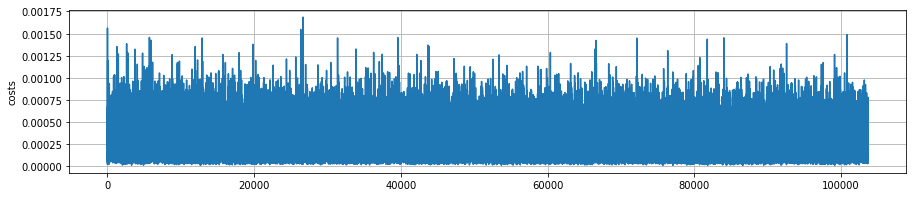


epoch14
Iteration  10371  ( 10.0 %) Train mean loss:  0.00027726643  ( std:  0.00016120182 ) ; run time:  29 [s]
Iteration  20740  ( 20.0 %) Train mean loss:  0.00027611005  ( std:  0.00016078957 ) ; run time:  59 [s]
Iteration  31113  ( 30.0 %) Train mean loss:  0.00027538693  ( std:  0.0001603792 ) ; run time:  89 [s]
Iteration  41483  ( 40.0 %) Train mean loss:  0.00027495337  ( std:  0.00015997211 ) ; run time:  119 [s]
Iteration  51852  ( 50.0 %) Train mean loss:  0.0002739917  ( std:  0.00015968615 ) ; run time:  148 [s]
Iteration  62219  ( 60.0 %) Train mean loss:  0.00027320356  ( std:  0.0001590148 ) ; run time:  178 [s]
Iteration  72586  ( 70.0 %) Train mean loss:  0.0002723229  ( std:  0.00015845877 ) ; run time:  207 [s]
Iteration  82956  ( 80.0 %) Train mean loss:  0.00027139237  ( std:  0.0001581061 ) ; run time:  237 [s]
Iteration  93331  ( 90.0 %) Train mean loss:  0.00027077814  ( std:  0.00015767616 ) ; run time:  267 [s]
Iteration  103713  ( 100.0 %) Train mean loss

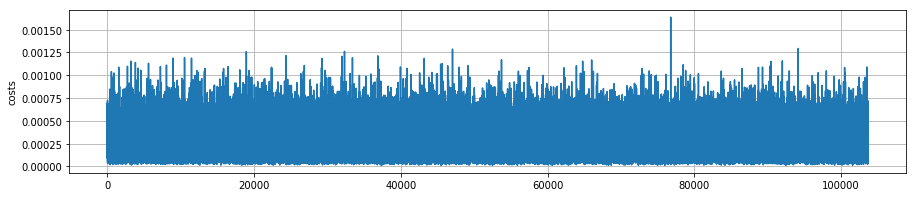


epoch15
Iteration  10373  ( 10.0 %) Train mean loss:  0.00025773275  ( std:  0.00015025938 ) ; run time:  29 [s]
Iteration  20746  ( 20.0 %) Train mean loss:  0.0002581255  ( std:  0.00014934171 ) ; run time:  59 [s]
Iteration  31124  ( 30.0 %) Train mean loss:  0.0002575816  ( std:  0.00014939146 ) ; run time:  88 [s]
Iteration  41490  ( 40.0 %) Train mean loss:  0.00025638458  ( std:  0.00014842238 ) ; run time:  118 [s]
Iteration  51865  ( 50.0 %) Train mean loss:  0.00025523224  ( std:  0.00014783641 ) ; run time:  148 [s]
Iteration  62229  ( 60.0 %) Train mean loss:  0.0002542137  ( std:  0.0001472681 ) ; run time:  178 [s]
Iteration  72601  ( 70.0 %) Train mean loss:  0.000253392  ( std:  0.00014645913 ) ; run time:  207 [s]
Iteration  82961  ( 80.0 %) Train mean loss:  0.0002525906  ( std:  0.00014607023 ) ; run time:  237 [s]
Iteration  93340  ( 90.0 %) Train mean loss:  0.0002517227  ( std:  0.00014558782 ) ; run time:  267 [s]
Iteration  103705  ( 100.0 %) Train mean loss:  

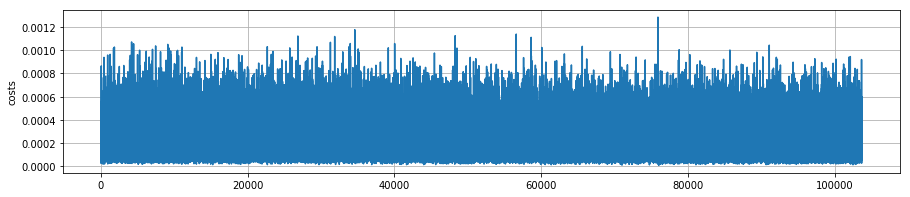


epoch16
Iteration  10374  ( 10.0 %) Train mean loss:  0.00024138928  ( std:  0.00014016645 ) ; run time:  29 [s]
Iteration  20743  ( 20.0 %) Train mean loss:  0.00024059557  ( std:  0.00013944272 ) ; run time:  59 [s]
Iteration  31118  ( 30.0 %) Train mean loss:  0.00023962809  ( std:  0.00013964904 ) ; run time:  89 [s]
Iteration  41497  ( 40.0 %) Train mean loss:  0.00023919043  ( std:  0.00013929386 ) ; run time:  118 [s]
Iteration  51860  ( 50.0 %) Train mean loss:  0.00023848149  ( std:  0.00013881079 ) ; run time:  148 [s]
Iteration  62225  ( 60.0 %) Train mean loss:  0.00023777054  ( std:  0.00013865305 ) ; run time:  178 [s]
Iteration  72602  ( 70.0 %) Train mean loss:  0.00023688562  ( std:  0.00013826026 ) ; run time:  207 [s]
Iteration  82971  ( 80.0 %) Train mean loss:  0.00023645125  ( std:  0.00013806125 ) ; run time:  237 [s]
Iteration  93336  ( 90.0 %) Train mean loss:  0.00023583576  ( std:  0.0001377744 ) ; run time:  267 [s]
Iteration  103699  ( 100.0 %) Train mean 

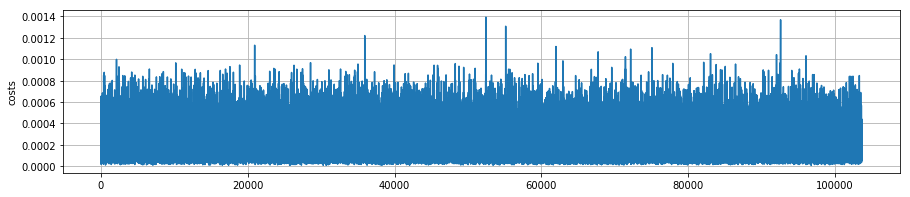


epoch17
Iteration  10366  ( 10.0 %) Train mean loss:  0.00022703019  ( std:  0.0001320457 ) ; run time:  29 [s]
Iteration  20741  ( 20.0 %) Train mean loss:  0.00022694531  ( std:  0.00013171826 ) ; run time:  59 [s]
Iteration  31111  ( 30.0 %) Train mean loss:  0.00022575501  ( std:  0.00013119576 ) ; run time:  89 [s]
Iteration  41486  ( 40.0 %) Train mean loss:  0.00022494218  ( std:  0.00013034002 ) ; run time:  119 [s]
Iteration  51870  ( 50.0 %) Train mean loss:  0.0002242819  ( std:  0.00013012574 ) ; run time:  148 [s]
Iteration  62234  ( 60.0 %) Train mean loss:  0.00022324236  ( std:  0.00012963386 ) ; run time:  178 [s]
Iteration  72609  ( 70.0 %) Train mean loss:  0.00022257978  ( std:  0.00012915142 ) ; run time:  208 [s]
Iteration  82988  ( 80.0 %) Train mean loss:  0.000222025  ( std:  0.00012884267 ) ; run time:  238 [s]
Iteration  93357  ( 90.0 %) Train mean loss:  0.00022160973  ( std:  0.00012854139 ) ; run time:  267 [s]
Iteration  103718  ( 100.0 %) Train mean los

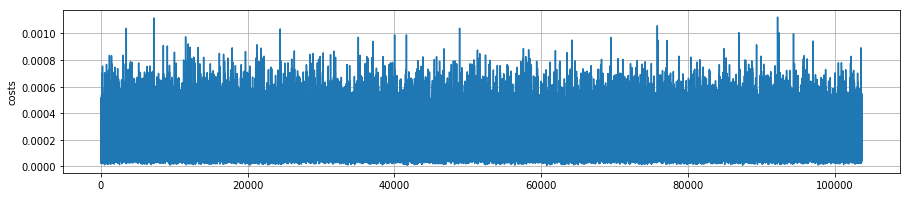


epoch18
Iteration  10374  ( 10.0 %) Train mean loss:  0.00021248142  ( std:  0.00012220399 ) ; run time:  29 [s]
Iteration  20747  ( 20.0 %) Train mean loss:  0.00021240051  ( std:  0.00012256946 ) ; run time:  58 [s]
Iteration  31112  ( 30.0 %) Train mean loss:  0.00021240531  ( std:  0.00012285722 ) ; run time:  88 [s]
Iteration  41485  ( 40.0 %) Train mean loss:  0.00021191331  ( std:  0.00012274788 ) ; run time:  117 [s]
Iteration  51856  ( 50.0 %) Train mean loss:  0.00021149863  ( std:  0.00012263416 ) ; run time:  147 [s]
Iteration  62236  ( 60.0 %) Train mean loss:  0.00021088525  ( std:  0.00012240192 ) ; run time:  176 [s]
Iteration  72600  ( 70.0 %) Train mean loss:  0.00021037072  ( std:  0.0001224154 ) ; run time:  206 [s]
Iteration  82977  ( 80.0 %) Train mean loss:  0.00020945801  ( std:  0.00012180034 ) ; run time:  235 [s]
Iteration  93334  ( 90.0 %) Train mean loss:  0.00020894692  ( std:  0.00012165694 ) ; run time:  265 [s]
Iteration  103703  ( 100.0 %) Train mean 

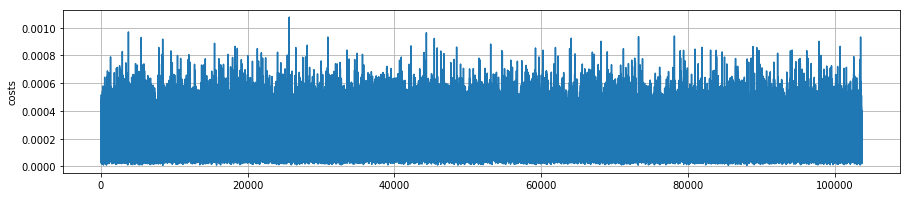


epoch19
Iteration  10366  ( 10.0 %) Train mean loss:  0.00020129058  ( std:  0.00011622836 ) ; run time:  29 [s]
Iteration  20734  ( 20.0 %) Train mean loss:  0.00020114564  ( std:  0.00011623873 ) ; run time:  58 [s]
Iteration  31106  ( 30.0 %) Train mean loss:  0.00020006594  ( std:  0.00011616399 ) ; run time:  88 [s]
Iteration  41477  ( 40.0 %) Train mean loss:  0.0001993469  ( std:  0.000115541465 ) ; run time:  118 [s]
Iteration  51850  ( 50.0 %) Train mean loss:  0.00019931878  ( std:  0.00011550229 ) ; run time:  147 [s]
Iteration  62222  ( 60.0 %) Train mean loss:  0.00019873209  ( std:  0.00011547773 ) ; run time:  176 [s]
Iteration  72595  ( 70.0 %) Train mean loss:  0.0001983046  ( std:  0.0001154018 ) ; run time:  206 [s]
Iteration  82968  ( 80.0 %) Train mean loss:  0.00019786743  ( std:  0.000115097246 ) ; run time:  236 [s]
Iteration  93336  ( 90.0 %) Train mean loss:  0.00019718477  ( std:  0.000114676805 ) ; run time:  265 [s]
Iteration  103709  ( 100.0 %) Train mean

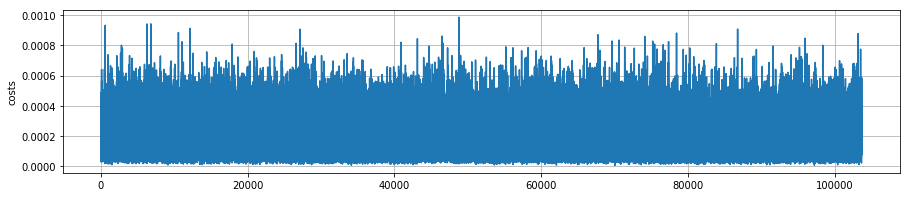


epoch20
Iteration  10367  ( 10.0 %) Train mean loss:  0.0001897896  ( std:  0.00011138527 ) ; run time:  29 [s]
Iteration  20734  ( 20.0 %) Train mean loss:  0.00019001712  ( std:  0.00011129606 ) ; run time:  59 [s]
Iteration  31114  ( 30.0 %) Train mean loss:  0.000190079  ( std:  0.000110998546 ) ; run time:  89 [s]
Iteration  41497  ( 40.0 %) Train mean loss:  0.00018964263  ( std:  0.000110337925 ) ; run time:  118 [s]
Iteration  51866  ( 50.0 %) Train mean loss:  0.00018911314  ( std:  0.000109879096 ) ; run time:  148 [s]
Iteration  62227  ( 60.0 %) Train mean loss:  0.00018872943  ( std:  0.000109572604 ) ; run time:  178 [s]
Iteration  72606  ( 70.0 %) Train mean loss:  0.0001883231  ( std:  0.00010914895 ) ; run time:  208 [s]
Iteration  82975  ( 80.0 %) Train mean loss:  0.00018782407  ( std:  0.0001089325 ) ; run time:  238 [s]
Iteration  93350  ( 90.0 %) Train mean loss:  0.00018732928  ( std:  0.00010866191 ) ; run time:  267 [s]
Iteration  103721  ( 100.0 %) Train mean 

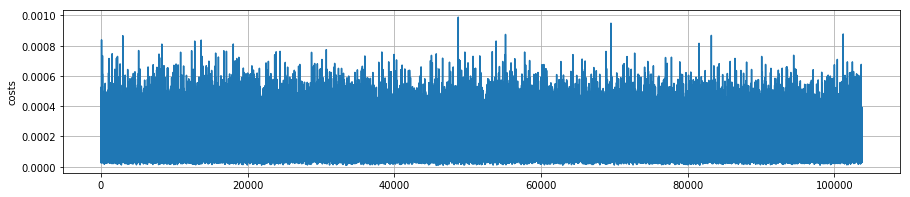


epoch21
Iteration  10362  ( 10.0 %) Train mean loss:  0.00018149732  ( std:  0.00010494251 ) ; run time:  29 [s]
Iteration  20745  ( 20.0 %) Train mean loss:  0.00018084772  ( std:  0.00010471533 ) ; run time:  59 [s]
Iteration  31117  ( 30.0 %) Train mean loss:  0.00018018446  ( std:  0.000104194136 ) ; run time:  89 [s]
Iteration  41490  ( 40.0 %) Train mean loss:  0.00017990074  ( std:  0.00010397076 ) ; run time:  119 [s]
Iteration  51854  ( 50.0 %) Train mean loss:  0.00017952094  ( std:  0.000103742896 ) ; run time:  148 [s]
Iteration  62228  ( 60.0 %) Train mean loss:  0.00017945953  ( std:  0.00010376064 ) ; run time:  178 [s]
Iteration  72597  ( 70.0 %) Train mean loss:  0.00017925014  ( std:  0.00010387543 ) ; run time:  208 [s]
Iteration  82970  ( 80.0 %) Train mean loss:  0.00017884673  ( std:  0.00010351582 ) ; run time:  237 [s]
Iteration  93354  ( 90.0 %) Train mean loss:  0.00017848753  ( std:  0.000103363345 ) ; run time:  267 [s]
Iteration  103723  ( 100.0 %) Train m

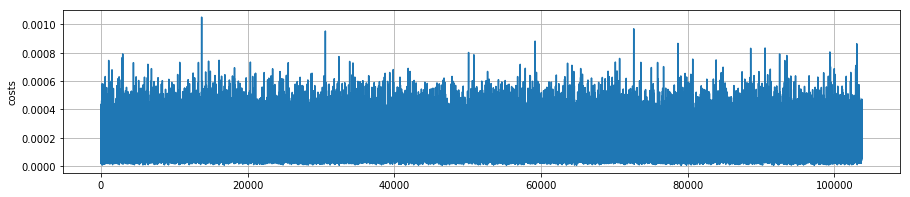


epoch22
Iteration  10375  ( 10.0 %) Train mean loss:  0.00017411541  ( std:  0.00010000779 ) ; run time:  29 [s]
Iteration  20740  ( 20.0 %) Train mean loss:  0.00017263391  ( std:  9.9701734e-05 ) ; run time:  59 [s]
Iteration  31109  ( 30.0 %) Train mean loss:  0.00017239794  ( std:  9.9836616e-05 ) ; run time:  89 [s]
Iteration  41480  ( 40.0 %) Train mean loss:  0.00017128747  ( std:  9.938296e-05 ) ; run time:  118 [s]
Iteration  51857  ( 50.0 %) Train mean loss:  0.00017099216  ( std:  9.917192e-05 ) ; run time:  148 [s]
Iteration  62222  ( 60.0 %) Train mean loss:  0.00017052433  ( std:  9.9151024e-05 ) ; run time:  178 [s]
Iteration  72593  ( 70.0 %) Train mean loss:  0.0001701311  ( std:  9.891116e-05 ) ; run time:  208 [s]
Iteration  82964  ( 80.0 %) Train mean loss:  0.00016971535  ( std:  9.8779645e-05 ) ; run time:  237 [s]
Iteration  93336  ( 90.0 %) Train mean loss:  0.00016927603  ( std:  9.84751e-05 ) ; run time:  267 [s]
Iteration  103710  ( 100.0 %) Train mean loss:

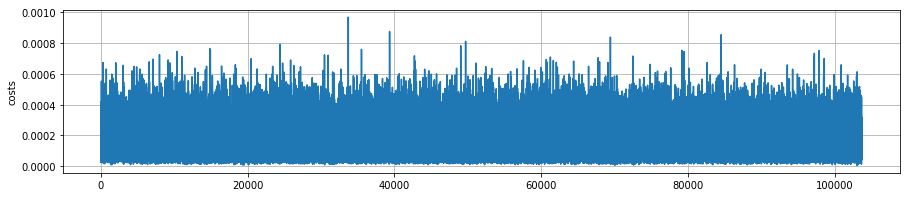


epoch23
Iteration  10376  ( 10.0 %) Train mean loss:  0.00016597794  ( std:  9.5914125e-05 ) ; run time:  29 [s]
Iteration  20736  ( 20.0 %) Train mean loss:  0.00016516482  ( std:  9.5158095e-05 ) ; run time:  59 [s]
Iteration  31100  ( 30.0 %) Train mean loss:  0.0001643344  ( std:  9.425756e-05 ) ; run time:  89 [s]
Iteration  41470  ( 40.0 %) Train mean loss:  0.00016402674  ( std:  9.427747e-05 ) ; run time:  118 [s]
Iteration  51843  ( 50.0 %) Train mean loss:  0.00016348575  ( std:  9.452877e-05 ) ; run time:  148 [s]
Iteration  62216  ( 60.0 %) Train mean loss:  0.00016311697  ( std:  9.438062e-05 ) ; run time:  177 [s]
Iteration  72578  ( 70.0 %) Train mean loss:  0.00016295642  ( std:  9.4276555e-05 ) ; run time:  207 [s]
Iteration  82953  ( 80.0 %) Train mean loss:  0.00016268656  ( std:  9.415568e-05 ) ; run time:  237 [s]
Iteration  93328  ( 90.0 %) Train mean loss:  0.00016244696  ( std:  9.405957e-05 ) ; run time:  266 [s]
Iteration  103704  ( 100.0 %) Train mean loss: 

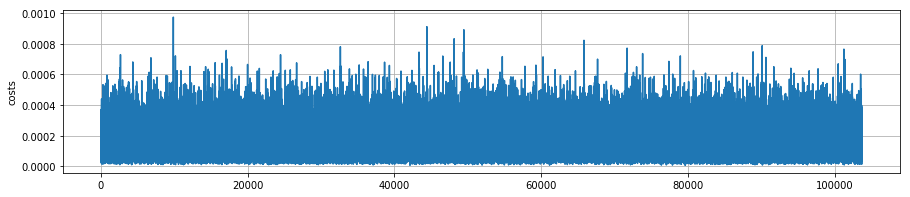


epoch24
Iteration  10369  ( 10.0 %) Train mean loss:  0.0001591876  ( std:  9.2181785e-05 ) ; run time:  29 [s]
Iteration  20751  ( 20.0 %) Train mean loss:  0.00015820407  ( std:  9.132833e-05 ) ; run time:  59 [s]
Iteration  31124  ( 30.0 %) Train mean loss:  0.00015763436  ( std:  9.161974e-05 ) ; run time:  88 [s]
Iteration  41493  ( 40.0 %) Train mean loss:  0.000156923  ( std:  9.093056e-05 ) ; run time:  118 [s]
Iteration  51861  ( 50.0 %) Train mean loss:  0.00015694422  ( std:  9.086863e-05 ) ; run time:  148 [s]
Iteration  62232  ( 60.0 %) Train mean loss:  0.00015654978  ( std:  9.066061e-05 ) ; run time:  177 [s]
Iteration  72599  ( 70.0 %) Train mean loss:  0.00015649103  ( std:  9.06277e-05 ) ; run time:  207 [s]
Iteration  82970  ( 80.0 %) Train mean loss:  0.00015595378  ( std:  9.0330155e-05 ) ; run time:  237 [s]
Iteration  93344  ( 90.0 %) Train mean loss:  0.00015554829  ( std:  9.021065e-05 ) ; run time:  266 [s]
Iteration  103709  ( 100.0 %) Train mean loss:  0.0

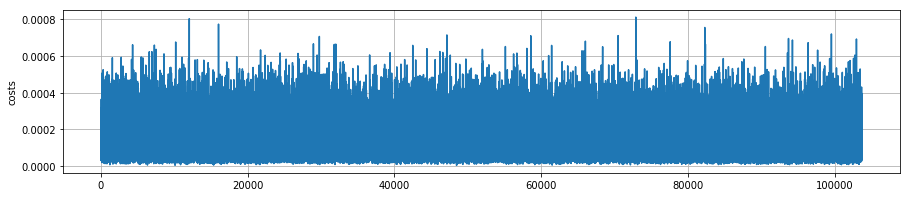


epoch25
Iteration  10370  ( 10.0 %) Train mean loss:  0.00015203253  ( std:  8.721874e-05 ) ; run time:  29 [s]
Iteration  20727  ( 20.0 %) Train mean loss:  0.00015090755  ( std:  8.711691e-05 ) ; run time:  59 [s]
Iteration  31104  ( 30.0 %) Train mean loss:  0.0001505644  ( std:  8.6884196e-05 ) ; run time:  89 [s]
Iteration  41473  ( 40.0 %) Train mean loss:  0.00015035427  ( std:  8.686352e-05 ) ; run time:  118 [s]
Iteration  51841  ( 50.0 %) Train mean loss:  0.00015013006  ( std:  8.675022e-05 ) ; run time:  148 [s]
Iteration  62216  ( 60.0 %) Train mean loss:  0.00014981112  ( std:  8.664095e-05 ) ; run time:  177 [s]
Iteration  72590  ( 70.0 %) Train mean loss:  0.00014930837  ( std:  8.639712e-05 ) ; run time:  207 [s]
Iteration  82963  ( 80.0 %) Train mean loss:  0.00014906183  ( std:  8.61536e-05 ) ; run time:  236 [s]
Iteration  93330  ( 90.0 %) Train mean loss:  0.00014884684  ( std:  8.606502e-05 ) ; run time:  266 [s]
Iteration  103698  ( 100.0 %) Train mean loss:  0.

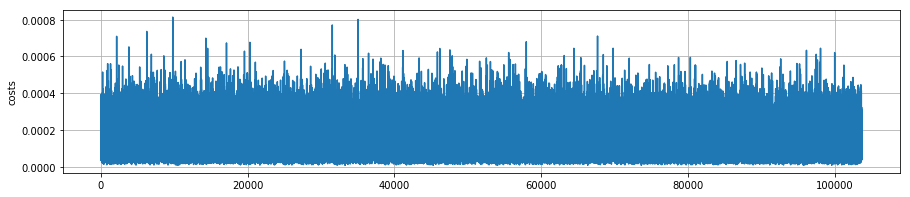


epoch26
Iteration  10367  ( 10.0 %) Train mean loss:  0.00014593653  ( std:  8.467083e-05 ) ; run time:  29 [s]
Iteration  20746  ( 20.0 %) Train mean loss:  0.00014584087  ( std:  8.504733e-05 ) ; run time:  59 [s]
Iteration  31121  ( 30.0 %) Train mean loss:  0.00014542961  ( std:  8.487021e-05 ) ; run time:  89 [s]
Iteration  41485  ( 40.0 %) Train mean loss:  0.00014510361  ( std:  8.47866e-05 ) ; run time:  118 [s]
Iteration  51857  ( 50.0 %) Train mean loss:  0.0001448785  ( std:  8.4629464e-05 ) ; run time:  148 [s]
Iteration  62223  ( 60.0 %) Train mean loss:  0.00014443434  ( std:  8.445147e-05 ) ; run time:  178 [s]
Iteration  72601  ( 70.0 %) Train mean loss:  0.00014420286  ( std:  8.424516e-05 ) ; run time:  208 [s]
Iteration  82980  ( 80.0 %) Train mean loss:  0.00014367234  ( std:  8.379138e-05 ) ; run time:  238 [s]
Iteration  93348  ( 90.0 %) Train mean loss:  0.0001435189  ( std:  8.368299e-05 ) ; run time:  267 [s]
Iteration  103728  ( 100.0 %) Train mean loss:  0.0

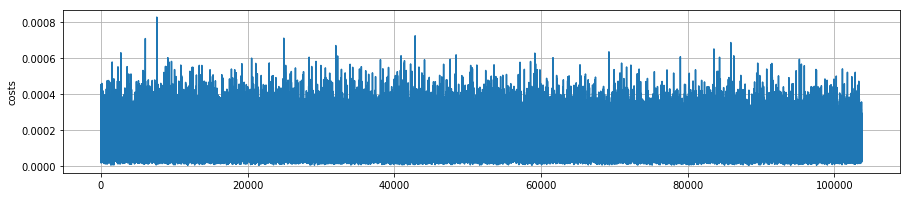


epoch27
Iteration  10375  ( 10.0 %) Train mean loss:  0.00013922722  ( std:  8.012334e-05 ) ; run time:  29 [s]
Iteration  20737  ( 20.0 %) Train mean loss:  0.00013872795  ( std:  7.984993e-05 ) ; run time:  59 [s]
Iteration  31099  ( 30.0 %) Train mean loss:  0.00013867908  ( std:  7.983448e-05 ) ; run time:  89 [s]
Iteration  41469  ( 40.0 %) Train mean loss:  0.00013872432  ( std:  8.01723e-05 ) ; run time:  118 [s]
Iteration  51838  ( 50.0 %) Train mean loss:  0.00013859347  ( std:  8.000814e-05 ) ; run time:  148 [s]
Iteration  62219  ( 60.0 %) Train mean loss:  0.00013824683  ( std:  7.97599e-05 ) ; run time:  178 [s]
Iteration  72588  ( 70.0 %) Train mean loss:  0.00013807518  ( std:  7.970105e-05 ) ; run time:  207 [s]
Iteration  82961  ( 80.0 %) Train mean loss:  0.00013789053  ( std:  7.952339e-05 ) ; run time:  237 [s]
Iteration  93335  ( 90.0 %) Train mean loss:  0.00013766317  ( std:  7.9576836e-05 ) ; run time:  267 [s]
Iteration  103704  ( 100.0 %) Train mean loss:  0.

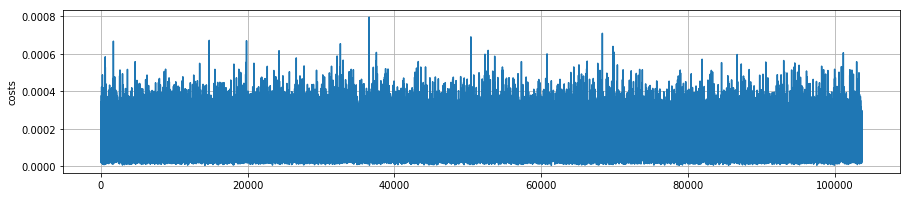


epoch28
Iteration  10362  ( 10.0 %) Train mean loss:  0.00013429685  ( std:  7.8245816e-05 ) ; run time:  29 [s]
Iteration  20744  ( 20.0 %) Train mean loss:  0.00013458384  ( std:  7.81276e-05 ) ; run time:  59 [s]
Iteration  31118  ( 30.0 %) Train mean loss:  0.00013419433  ( std:  7.7519006e-05 ) ; run time:  89 [s]
Iteration  41481  ( 40.0 %) Train mean loss:  0.00013367757  ( std:  7.7390716e-05 ) ; run time:  119 [s]
Iteration  51858  ( 50.0 %) Train mean loss:  0.00013356557  ( std:  7.724512e-05 ) ; run time:  148 [s]
Iteration  62223  ( 60.0 %) Train mean loss:  0.00013342332  ( std:  7.715828e-05 ) ; run time:  178 [s]
Iteration  72591  ( 70.0 %) Train mean loss:  0.00013328665  ( std:  7.701497e-05 ) ; run time:  207 [s]
Iteration  82961  ( 80.0 %) Train mean loss:  0.00013309273  ( std:  7.691646e-05 ) ; run time:  237 [s]
Iteration  93330  ( 90.0 %) Train mean loss:  0.00013288534  ( std:  7.6750504e-05 ) ; run time:  267 [s]
Iteration  103707  ( 100.0 %) Train mean loss:

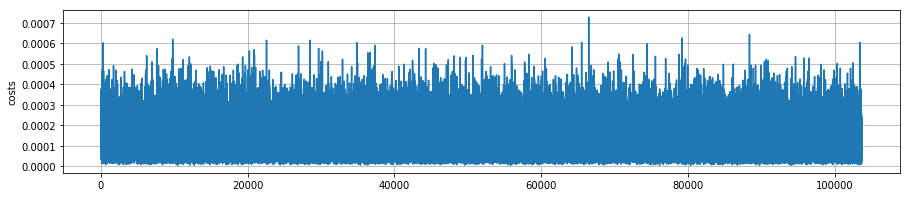


epoch29
Iteration  10371  ( 10.0 %) Train mean loss:  0.00013103458  ( std:  7.545853e-05 ) ; run time:  29 [s]
Iteration  20746  ( 20.0 %) Train mean loss:  0.00013016265  ( std:  7.494278e-05 ) ; run time:  59 [s]
Iteration  31118  ( 30.0 %) Train mean loss:  0.00012923709  ( std:  7.463098e-05 ) ; run time:  89 [s]
Iteration  41500  ( 40.0 %) Train mean loss:  0.00012892537  ( std:  7.4330266e-05 ) ; run time:  119 [s]
Iteration  51868  ( 50.0 %) Train mean loss:  0.00012878088  ( std:  7.430757e-05 ) ; run time:  148 [s]
Iteration  62225  ( 60.0 %) Train mean loss:  0.00012869842  ( std:  7.438129e-05 ) ; run time:  178 [s]
Iteration  72596  ( 70.0 %) Train mean loss:  0.00012845367  ( std:  7.4203104e-05 ) ; run time:  208 [s]
Iteration  82972  ( 80.0 %) Train mean loss:  0.00012839165  ( std:  7.4198724e-05 ) ; run time:  238 [s]
Iteration  93326  ( 90.0 %) Train mean loss:  0.00012827694  ( std:  7.422749e-05 ) ; run time:  268 [s]
Iteration  103689  ( 100.0 %) Train mean loss:

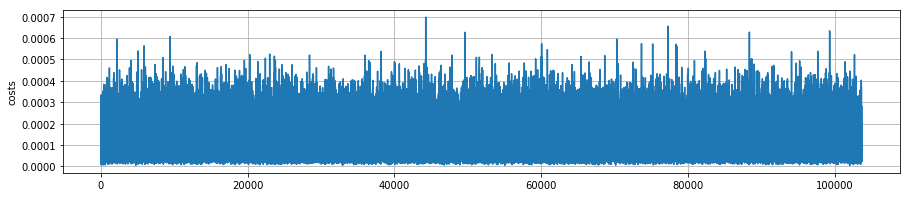


epoch30
Iteration  10371  ( 10.0 %) Train mean loss:  0.00012428605  ( std:  7.1656075e-05 ) ; run time:  29 [s]
Iteration  20742  ( 20.0 %) Train mean loss:  0.00012446726  ( std:  7.176301e-05 ) ; run time:  59 [s]
Iteration  31121  ( 30.0 %) Train mean loss:  0.00012463331  ( std:  7.160259e-05 ) ; run time:  89 [s]
Iteration  41495  ( 40.0 %) Train mean loss:  0.00012436492  ( std:  7.172125e-05 ) ; run time:  119 [s]
Iteration  51863  ( 50.0 %) Train mean loss:  0.00012424948  ( std:  7.169498e-05 ) ; run time:  148 [s]
Iteration  62225  ( 60.0 %) Train mean loss:  0.00012411222  ( std:  7.1635346e-05 ) ; run time:  178 [s]
Iteration  72595  ( 70.0 %) Train mean loss:  0.00012404131  ( std:  7.160624e-05 ) ; run time:  208 [s]
Iteration  82972  ( 80.0 %) Train mean loss:  0.00012394121  ( std:  7.155202e-05 ) ; run time:  238 [s]
Iteration  93335  ( 90.0 %) Train mean loss:  0.00012372137  ( std:  7.146348e-05 ) ; run time:  267 [s]
Iteration  103710  ( 100.0 %) Train mean loss: 

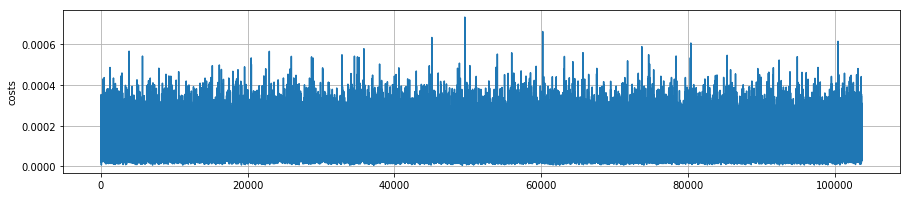


epoch31
Iteration  10377  ( 10.0 %) Train mean loss:  0.000120777404  ( std:  6.9363734e-05 ) ; run time:  29 [s]
Iteration  20750  ( 20.0 %) Train mean loss:  0.00012152446  ( std:  7.0305105e-05 ) ; run time:  58 [s]
Iteration  31116  ( 30.0 %) Train mean loss:  0.000121172125  ( std:  7.028889e-05 ) ; run time:  88 [s]
Iteration  41496  ( 40.0 %) Train mean loss:  0.000120932906  ( std:  6.9966765e-05 ) ; run time:  117 [s]
Iteration  51859  ( 50.0 %) Train mean loss:  0.00012090973  ( std:  7.001569e-05 ) ; run time:  147 [s]
Iteration  62232  ( 60.0 %) Train mean loss:  0.000120741504  ( std:  6.9749956e-05 ) ; run time:  176 [s]
Iteration  72595  ( 70.0 %) Train mean loss:  0.00012064518  ( std:  6.971335e-05 ) ; run time:  206 [s]
Iteration  82969  ( 80.0 %) Train mean loss:  0.00012047437  ( std:  6.969018e-05 ) ; run time:  235 [s]
Iteration  93340  ( 90.0 %) Train mean loss:  0.00012035889  ( std:  6.9593625e-05 ) ; run time:  265 [s]
Iteration  103711  ( 100.0 %) Train mean

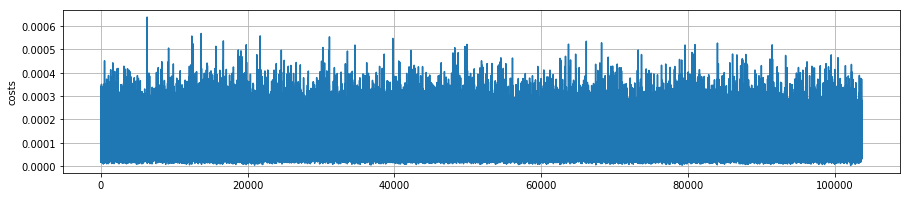


epoch32
Iteration  10365  ( 10.0 %) Train mean loss:  0.00011810228  ( std:  6.829582e-05 ) ; run time:  29 [s]
Iteration  20737  ( 20.0 %) Train mean loss:  0.0001176447  ( std:  6.849001e-05 ) ; run time:  59 [s]
Iteration  31117  ( 30.0 %) Train mean loss:  0.000117146286  ( std:  6.788526e-05 ) ; run time:  89 [s]
Iteration  41489  ( 40.0 %) Train mean loss:  0.00011676936  ( std:  6.777583e-05 ) ; run time:  118 [s]
Iteration  51855  ( 50.0 %) Train mean loss:  0.00011656997  ( std:  6.750958e-05 ) ; run time:  148 [s]
Iteration  62238  ( 60.0 %) Train mean loss:  0.0001161685  ( std:  6.729159e-05 ) ; run time:  178 [s]
Iteration  72600  ( 70.0 %) Train mean loss:  0.00011619451  ( std:  6.7384324e-05 ) ; run time:  207 [s]
Iteration  82978  ( 80.0 %) Train mean loss:  0.00011608941  ( std:  6.730187e-05 ) ; run time:  237 [s]
Iteration  93343  ( 90.0 %) Train mean loss:  0.00011585456  ( std:  6.710808e-05 ) ; run time:  267 [s]
Iteration  103706  ( 100.0 %) Train mean loss:  0

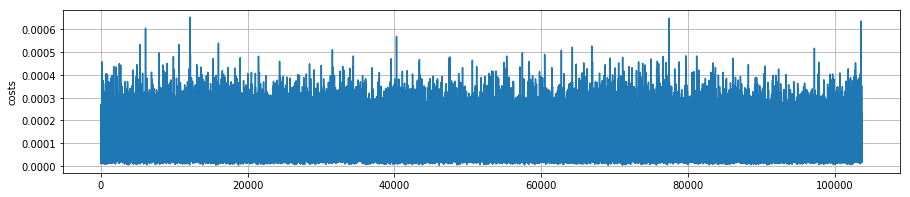


epoch33
Iteration  10375  ( 10.0 %) Train mean loss:  0.00011402654  ( std:  6.65555e-05 ) ; run time:  29 [s]
Iteration  20746  ( 20.0 %) Train mean loss:  0.00011404717  ( std:  6.663353e-05 ) ; run time:  59 [s]
Iteration  31126  ( 30.0 %) Train mean loss:  0.00011392972  ( std:  6.621536e-05 ) ; run time:  89 [s]
Iteration  41499  ( 40.0 %) Train mean loss:  0.000113691  ( std:  6.596545e-05 ) ; run time:  119 [s]
Iteration  51861  ( 50.0 %) Train mean loss:  0.000113502785  ( std:  6.569262e-05 ) ; run time:  148 [s]
Iteration  62238  ( 60.0 %) Train mean loss:  0.00011319198  ( std:  6.55721e-05 ) ; run time:  177 [s]
Iteration  72605  ( 70.0 %) Train mean loss:  0.000113189664  ( std:  6.540754e-05 ) ; run time:  207 [s]
Iteration  82971  ( 80.0 %) Train mean loss:  0.00011293135  ( std:  6.5301625e-05 ) ; run time:  236 [s]
Iteration  93344  ( 90.0 %) Train mean loss:  0.00011269622  ( std:  6.526626e-05 ) ; run time:  266 [s]
Iteration  103713  ( 100.0 %) Train mean loss:  0.

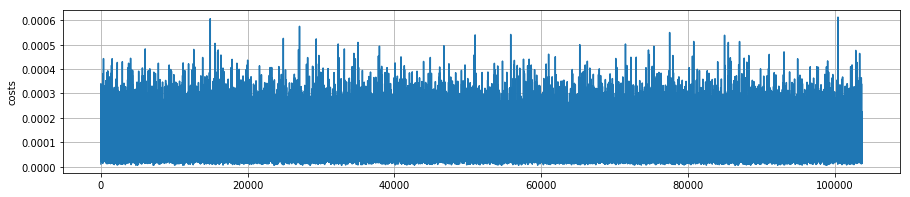


epoch34
Iteration  10386  ( 10.0 %) Train mean loss:  0.00011032098  ( std:  6.350011e-05 ) ; run time:  29 [s]
Iteration  20759  ( 20.0 %) Train mean loss:  0.000109896726  ( std:  6.326556e-05 ) ; run time:  58 [s]
Iteration  31130  ( 30.0 %) Train mean loss:  0.000110087836  ( std:  6.340409e-05 ) ; run time:  88 [s]
Iteration  41506  ( 40.0 %) Train mean loss:  0.00010991749  ( std:  6.33605e-05 ) ; run time:  117 [s]
Iteration  51870  ( 50.0 %) Train mean loss:  0.00010974886  ( std:  6.3353655e-05 ) ; run time:  147 [s]
Iteration  62237  ( 60.0 %) Train mean loss:  0.00010978261  ( std:  6.3353604e-05 ) ; run time:  176 [s]
Iteration  72603  ( 70.0 %) Train mean loss:  0.000109750785  ( std:  6.3236e-05 ) ; run time:  205 [s]
Iteration  82964  ( 80.0 %) Train mean loss:  0.00010955779  ( std:  6.3129206e-05 ) ; run time:  235 [s]
Iteration  93340  ( 90.0 %) Train mean loss:  0.00010949478  ( std:  6.303919e-05 ) ; run time:  264 [s]
Iteration  103715  ( 100.0 %) Train mean loss:

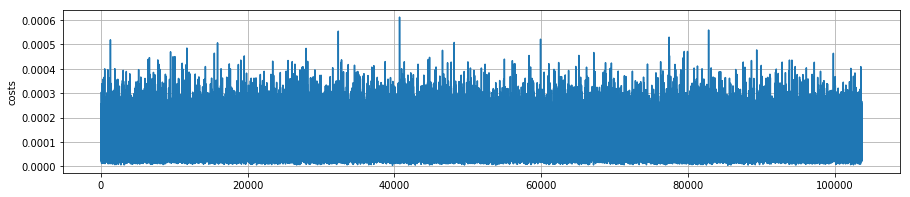


epoch35
Iteration  10355  ( 10.0 %) Train mean loss:  0.00010758661  ( std:  6.2784595e-05 ) ; run time:  29 [s]
Iteration  20730  ( 20.0 %) Train mean loss:  0.00010686458  ( std:  6.224345e-05 ) ; run time:  59 [s]
Iteration  31103  ( 30.0 %) Train mean loss:  0.00010678433  ( std:  6.221318e-05 ) ; run time:  88 [s]
Iteration  41476  ( 40.0 %) Train mean loss:  0.00010680897  ( std:  6.213722e-05 ) ; run time:  118 [s]
Iteration  51849  ( 50.0 %) Train mean loss:  0.000106673186  ( std:  6.211181e-05 ) ; run time:  147 [s]
Iteration  62232  ( 60.0 %) Train mean loss:  0.00010653181  ( std:  6.1865685e-05 ) ; run time:  177 [s]
Iteration  72595  ( 70.0 %) Train mean loss:  0.00010632317  ( std:  6.160197e-05 ) ; run time:  206 [s]
Iteration  82970  ( 80.0 %) Train mean loss:  0.00010604424  ( std:  6.1362625e-05 ) ; run time:  236 [s]
Iteration  93341  ( 90.0 %) Train mean loss:  0.00010588512  ( std:  6.131547e-05 ) ; run time:  265 [s]
Iteration  103704  ( 100.0 %) Train mean loss

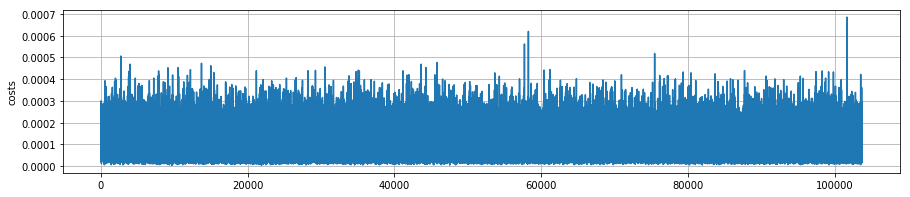


epoch36
Iteration  10374  ( 10.0 %) Train mean loss:  0.00010402619  ( std:  5.962441e-05 ) ; run time:  29 [s]
Iteration  20740  ( 20.0 %) Train mean loss:  0.00010359286  ( std:  5.9272843e-05 ) ; run time:  59 [s]
Iteration  31123  ( 30.0 %) Train mean loss:  0.000103789345  ( std:  5.9490405e-05 ) ; run time:  89 [s]
Iteration  41500  ( 40.0 %) Train mean loss:  0.0001039343  ( std:  5.9780392e-05 ) ; run time:  118 [s]
Iteration  51871  ( 50.0 %) Train mean loss:  0.00010373045  ( std:  5.9700073e-05 ) ; run time:  148 [s]
Iteration  62239  ( 60.0 %) Train mean loss:  0.000103419916  ( std:  5.9533908e-05 ) ; run time:  178 [s]
Iteration  72615  ( 70.0 %) Train mean loss:  0.00010329748  ( std:  5.9597227e-05 ) ; run time:  208 [s]
Iteration  82986  ( 80.0 %) Train mean loss:  0.00010320267  ( std:  5.967325e-05 ) ; run time:  238 [s]
Iteration  93365  ( 90.0 %) Train mean loss:  0.000103034705  ( std:  5.9519352e-05 ) ; run time:  267 [s]
Iteration  103736  ( 100.0 %) Train mean

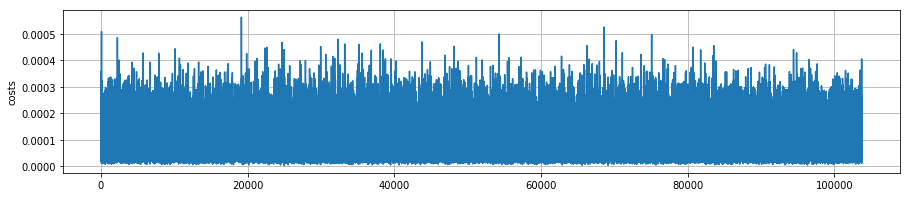


epoch37
Iteration  10365  ( 10.0 %) Train mean loss:  0.000102129605  ( std:  5.8408787e-05 ) ; run time:  29 [s]
Iteration  20742  ( 20.0 %) Train mean loss:  0.000101696845  ( std:  5.824534e-05 ) ; run time:  59 [s]
Iteration  31106  ( 30.0 %) Train mean loss:  0.00010163222  ( std:  5.8078054e-05 ) ; run time:  89 [s]
Iteration  41479  ( 40.0 %) Train mean loss:  0.000101342135  ( std:  5.789438e-05 ) ; run time:  119 [s]
Iteration  51852  ( 50.0 %) Train mean loss:  0.00010112674  ( std:  5.8052818e-05 ) ; run time:  148 [s]
Iteration  62225  ( 60.0 %) Train mean loss:  0.000101124344  ( std:  5.7962672e-05 ) ; run time:  178 [s]
Iteration  72599  ( 70.0 %) Train mean loss:  0.00010104537  ( std:  5.803374e-05 ) ; run time:  208 [s]
Iteration  82963  ( 80.0 %) Train mean loss:  0.00010084214  ( std:  5.7808196e-05 ) ; run time:  237 [s]
Iteration  93330  ( 90.0 %) Train mean loss:  0.00010074128  ( std:  5.786921e-05 ) ; run time:  267 [s]
Iteration  103704  ( 100.0 %) Train mean

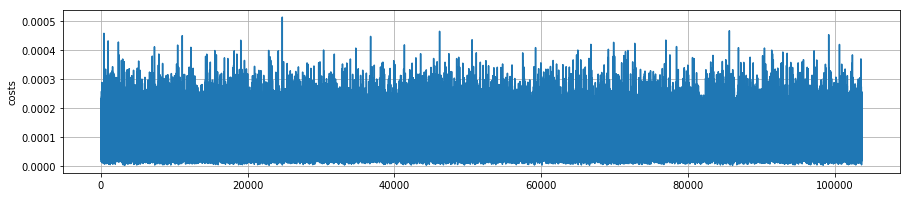


epoch38
Iteration  10369  ( 10.0 %) Train mean loss:  9.915502e-05  ( std:  5.703974e-05 ) ; run time:  29 [s]
Iteration  20737  ( 20.0 %) Train mean loss:  9.8869124e-05  ( std:  5.7001726e-05 ) ; run time:  59 [s]
Iteration  31109  ( 30.0 %) Train mean loss:  9.889144e-05  ( std:  5.7066765e-05 ) ; run time:  89 [s]
Iteration  41486  ( 40.0 %) Train mean loss:  9.833592e-05  ( std:  5.672104e-05 ) ; run time:  119 [s]
Iteration  51861  ( 50.0 %) Train mean loss:  9.8163e-05  ( std:  5.6610785e-05 ) ; run time:  149 [s]
Iteration  62224  ( 60.0 %) Train mean loss:  9.801252e-05  ( std:  5.6486595e-05 ) ; run time:  178 [s]
Iteration  72591  ( 70.0 %) Train mean loss:  9.791667e-05  ( std:  5.655594e-05 ) ; run time:  208 [s]
Iteration  82969  ( 80.0 %) Train mean loss:  9.782468e-05  ( std:  5.6469646e-05 ) ; run time:  238 [s]
Iteration  93339  ( 90.0 %) Train mean loss:  9.7672e-05  ( std:  5.6338664e-05 ) ; run time:  268 [s]
Iteration  103703  ( 100.0 %) Train mean loss:  9.76116

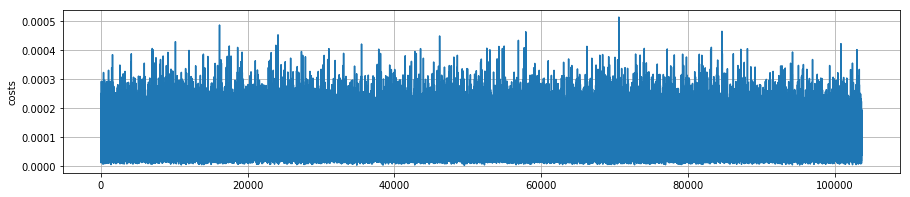


epoch39
Iteration  10367  ( 10.0 %) Train mean loss:  9.5270814e-05  ( std:  5.4953256e-05 ) ; run time:  29 [s]
Iteration  20735  ( 20.0 %) Train mean loss:  9.597136e-05  ( std:  5.48517e-05 ) ; run time:  59 [s]
Iteration  31106  ( 30.0 %) Train mean loss:  9.5766074e-05  ( std:  5.4803062e-05 ) ; run time:  89 [s]
Iteration  41484  ( 40.0 %) Train mean loss:  9.538071e-05  ( std:  5.4433207e-05 ) ; run time:  118 [s]
Iteration  51858  ( 50.0 %) Train mean loss:  9.524e-05  ( std:  5.4427288e-05 ) ; run time:  148 [s]
Iteration  62232  ( 60.0 %) Train mean loss:  9.502527e-05  ( std:  5.4361695e-05 ) ; run time:  178 [s]
Iteration  72603  ( 70.0 %) Train mean loss:  9.499986e-05  ( std:  5.4378597e-05 ) ; run time:  208 [s]
Iteration  82973  ( 80.0 %) Train mean loss:  9.488422e-05  ( std:  5.4420663e-05 ) ; run time:  238 [s]
Iteration  93332  ( 90.0 %) Train mean loss:  9.4820556e-05  ( std:  5.4461783e-05 ) ; run time:  267 [s]
Iteration  103719  ( 100.0 %) Train mean loss:  9.4

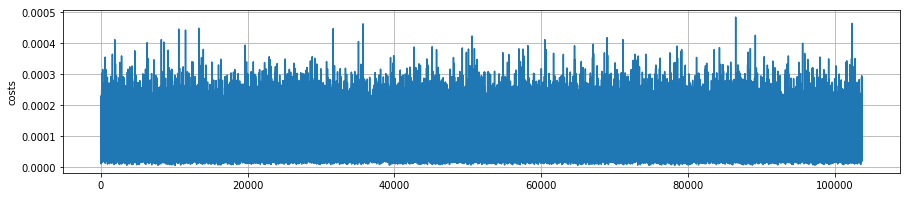


epoch40
Iteration  10365  ( 10.0 %) Train mean loss:  9.267482e-05  ( std:  5.43134e-05 ) ; run time:  29 [s]
Iteration  20743  ( 20.0 %) Train mean loss:  9.3610885e-05  ( std:  5.4299377e-05 ) ; run time:  59 [s]
Iteration  31110  ( 30.0 %) Train mean loss:  9.382374e-05  ( std:  5.4539603e-05 ) ; run time:  89 [s]
Iteration  41487  ( 40.0 %) Train mean loss:  9.359609e-05  ( std:  5.4305747e-05 ) ; run time:  119 [s]
Iteration  51864  ( 50.0 %) Train mean loss:  9.318806e-05  ( std:  5.41565e-05 ) ; run time:  148 [s]
Iteration  62246  ( 60.0 %) Train mean loss:  9.309056e-05  ( std:  5.403135e-05 ) ; run time:  178 [s]
Iteration  72617  ( 70.0 %) Train mean loss:  9.29799e-05  ( std:  5.387632e-05 ) ; run time:  208 [s]
Iteration  82986  ( 80.0 %) Train mean loss:  9.289243e-05  ( std:  5.385644e-05 ) ; run time:  237 [s]
Iteration  93355  ( 90.0 %) Train mean loss:  9.2832284e-05  ( std:  5.377361e-05 ) ; run time:  267 [s]
Iteration  103722  ( 100.0 %) Train mean loss:  9.271202

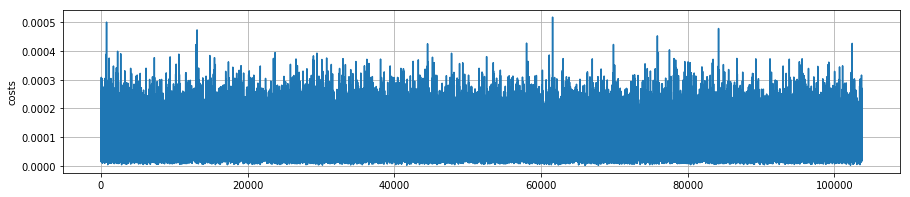


epoch41
Iteration  10375  ( 10.0 %) Train mean loss:  9.086677e-05  ( std:  5.220346e-05 ) ; run time:  29 [s]
Iteration  20754  ( 20.0 %) Train mean loss:  9.093038e-05  ( std:  5.2191626e-05 ) ; run time:  59 [s]
Iteration  31121  ( 30.0 %) Train mean loss:  9.091974e-05  ( std:  5.207693e-05 ) ; run time:  88 [s]
Iteration  41490  ( 40.0 %) Train mean loss:  9.0938825e-05  ( std:  5.2201158e-05 ) ; run time:  118 [s]
Iteration  51859  ( 50.0 %) Train mean loss:  9.0836584e-05  ( std:  5.206869e-05 ) ; run time:  148 [s]
Iteration  62226  ( 60.0 %) Train mean loss:  9.0780246e-05  ( std:  5.2132793e-05 ) ; run time:  178 [s]
Iteration  72598  ( 70.0 %) Train mean loss:  9.0630354e-05  ( std:  5.207012e-05 ) ; run time:  207 [s]
Iteration  82973  ( 80.0 %) Train mean loss:  9.057214e-05  ( std:  5.196913e-05 ) ; run time:  237 [s]
Iteration  93345  ( 90.0 %) Train mean loss:  9.042854e-05  ( std:  5.190659e-05 ) ; run time:  267 [s]
Iteration  103714  ( 100.0 %) Train mean loss:  9.0

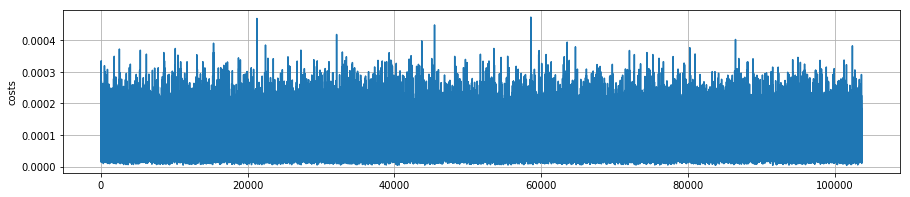


epoch42
Iteration  10371  ( 10.0 %) Train mean loss:  8.8325185e-05  ( std:  5.1154995e-05 ) ; run time:  30 [s]
Iteration  20732  ( 20.0 %) Train mean loss:  8.868093e-05  ( std:  5.141051e-05 ) ; run time:  59 [s]
Iteration  31097  ( 30.0 %) Train mean loss:  8.858707e-05  ( std:  5.125228e-05 ) ; run time:  89 [s]
Iteration  41471  ( 40.0 %) Train mean loss:  8.850791e-05  ( std:  5.133285e-05 ) ; run time:  119 [s]
Iteration  51841  ( 50.0 %) Train mean loss:  8.8429006e-05  ( std:  5.1054387e-05 ) ; run time:  149 [s]
Iteration  62215  ( 60.0 %) Train mean loss:  8.8456916e-05  ( std:  5.1068346e-05 ) ; run time:  178 [s]
Iteration  72592  ( 70.0 %) Train mean loss:  8.8328365e-05  ( std:  5.1117073e-05 ) ; run time:  208 [s]
Iteration  82976  ( 80.0 %) Train mean loss:  8.810286e-05  ( std:  5.0916344e-05 ) ; run time:  238 [s]
Iteration  93347  ( 90.0 %) Train mean loss:  8.7961176e-05  ( std:  5.0805735e-05 ) ; run time:  268 [s]
Iteration  103717  ( 100.0 %) Train mean loss: 

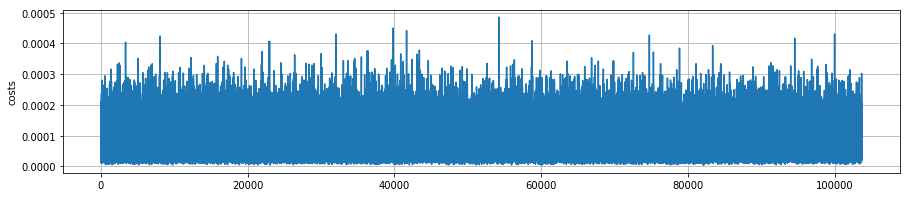


epoch43
Iteration  10365  ( 10.0 %) Train mean loss:  8.656338e-05  ( std:  4.996622e-05 ) ; run time:  29 [s]
Iteration  20741  ( 20.0 %) Train mean loss:  8.70782e-05  ( std:  5.0051513e-05 ) ; run time:  59 [s]
Iteration  31114  ( 30.0 %) Train mean loss:  8.678554e-05  ( std:  5.0026632e-05 ) ; run time:  89 [s]
Iteration  41489  ( 40.0 %) Train mean loss:  8.65502e-05  ( std:  4.9934843e-05 ) ; run time:  119 [s]
Iteration  51865  ( 50.0 %) Train mean loss:  8.6376225e-05  ( std:  4.985836e-05 ) ; run time:  149 [s]
Iteration  62226  ( 60.0 %) Train mean loss:  8.629932e-05  ( std:  4.970538e-05 ) ; run time:  178 [s]
Iteration  72593  ( 70.0 %) Train mean loss:  8.621726e-05  ( std:  4.96636e-05 ) ; run time:  208 [s]
Iteration  82968  ( 80.0 %) Train mean loss:  8.604879e-05  ( std:  4.9627204e-05 ) ; run time:  238 [s]
Iteration  93332  ( 90.0 %) Train mean loss:  8.592181e-05  ( std:  4.9448292e-05 ) ; run time:  267 [s]
Iteration  103698  ( 100.0 %) Train mean loss:  8.57830

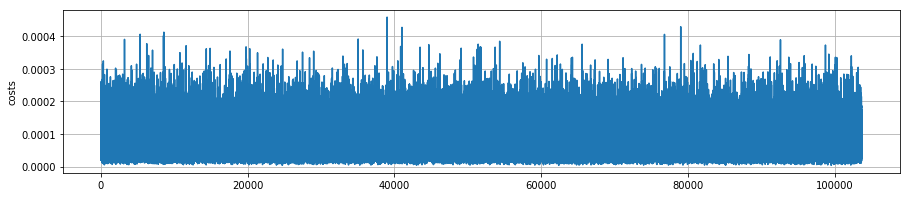


epoch44
Iteration  10366  ( 10.0 %) Train mean loss:  8.5047155e-05  ( std:  4.9026785e-05 ) ; run time:  29 [s]
Iteration  20740  ( 20.0 %) Train mean loss:  8.485823e-05  ( std:  4.9051385e-05 ) ; run time:  59 [s]
Iteration  31108  ( 30.0 %) Train mean loss:  8.481722e-05  ( std:  4.8905105e-05 ) ; run time:  89 [s]
Iteration  41488  ( 40.0 %) Train mean loss:  8.4413216e-05  ( std:  4.8797025e-05 ) ; run time:  118 [s]
Iteration  51852  ( 50.0 %) Train mean loss:  8.437302e-05  ( std:  4.867831e-05 ) ; run time:  148 [s]
Iteration  62232  ( 60.0 %) Train mean loss:  8.443977e-05  ( std:  4.8709397e-05 ) ; run time:  178 [s]
Iteration  72599  ( 70.0 %) Train mean loss:  8.442534e-05  ( std:  4.862229e-05 ) ; run time:  207 [s]
Iteration  82967  ( 80.0 %) Train mean loss:  8.430719e-05  ( std:  4.8615206e-05 ) ; run time:  237 [s]
Iteration  93330  ( 90.0 %) Train mean loss:  8.420145e-05  ( std:  4.8587535e-05 ) ; run time:  267 [s]
Iteration  103703  ( 100.0 %) Train mean loss:  8

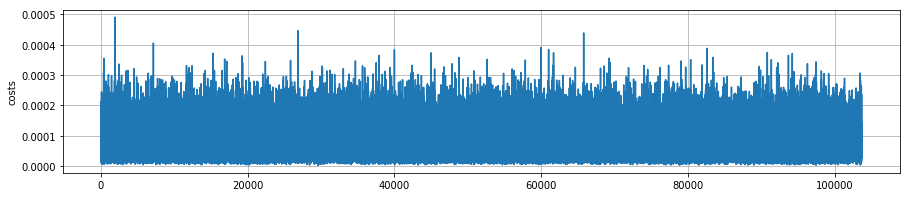


epoch45
Iteration  10367  ( 10.0 %) Train mean loss:  8.361618e-05  ( std:  4.8578568e-05 ) ; run time:  29 [s]
Iteration  20747  ( 20.0 %) Train mean loss:  8.318386e-05  ( std:  4.7956593e-05 ) ; run time:  59 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  8.322215e-05  ( std:  4.7991503e-05 ) ; run time:  89 [s]
Iteration  41490  ( 40.0 %) Train mean loss:  8.3006074e-05  ( std:  4.7731588e-05 ) ; run time:  118 [s]
Iteration  51862  ( 50.0 %) Train mean loss:  8.287505e-05  ( std:  4.7656253e-05 ) ; run time:  148 [s]
Iteration  62227  ( 60.0 %) Train mean loss:  8.267353e-05  ( std:  4.7599293e-05 ) ; run time:  178 [s]
Iteration  72601  ( 70.0 %) Train mean loss:  8.267358e-05  ( std:  4.7586287e-05 ) ; run time:  208 [s]
Iteration  82970  ( 80.0 %) Train mean loss:  8.26422e-05  ( std:  4.7584643e-05 ) ; run time:  237 [s]
Iteration  93341  ( 90.0 %) Train mean loss:  8.25362e-05  ( std:  4.7503912e-05 ) ; run time:  267 [s]
Iteration  103713  ( 100.0 %) Train mean loss:  8.

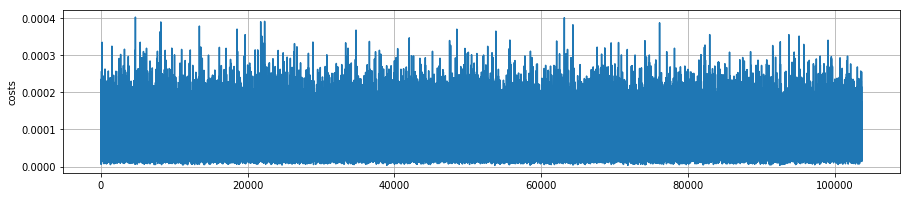


epoch46
Iteration  10374  ( 10.0 %) Train mean loss:  8.1285885e-05  ( std:  4.7078018e-05 ) ; run time:  29 [s]
Iteration  20745  ( 20.0 %) Train mean loss:  8.08039e-05  ( std:  4.712617e-05 ) ; run time:  59 [s]
Iteration  31122  ( 30.0 %) Train mean loss:  8.074967e-05  ( std:  4.7013647e-05 ) ; run time:  89 [s]
Iteration  41497  ( 40.0 %) Train mean loss:  8.0511214e-05  ( std:  4.687173e-05 ) ; run time:  119 [s]
Iteration  51860  ( 50.0 %) Train mean loss:  8.054999e-05  ( std:  4.6858753e-05 ) ; run time:  148 [s]
Iteration  62227  ( 60.0 %) Train mean loss:  8.0573715e-05  ( std:  4.67343e-05 ) ; run time:  178 [s]
Iteration  72599  ( 70.0 %) Train mean loss:  8.0481565e-05  ( std:  4.6664114e-05 ) ; run time:  208 [s]
Iteration  82959  ( 80.0 %) Train mean loss:  8.051357e-05  ( std:  4.661755e-05 ) ; run time:  237 [s]
Iteration  93338  ( 90.0 %) Train mean loss:  8.03936e-05  ( std:  4.6509165e-05 ) ; run time:  267 [s]
Iteration  103711  ( 100.0 %) Train mean loss:  8.03

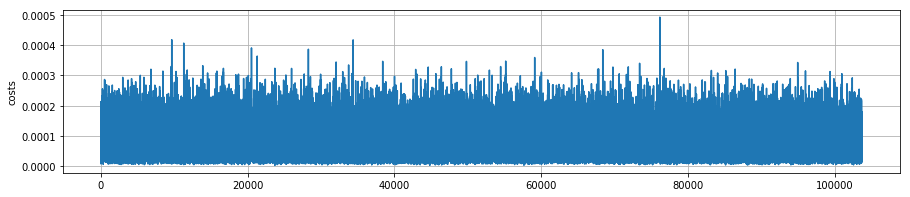


epoch47
Iteration  10373  ( 10.0 %) Train mean loss:  7.9796184e-05  ( std:  4.6332778e-05 ) ; run time:  29 [s]
Iteration  20751  ( 20.0 %) Train mean loss:  7.973931e-05  ( std:  4.60481e-05 ) ; run time:  59 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  7.914721e-05  ( std:  4.5913865e-05 ) ; run time:  89 [s]
Iteration  41498  ( 40.0 %) Train mean loss:  7.896952e-05  ( std:  4.5561555e-05 ) ; run time:  118 [s]
Iteration  51870  ( 50.0 %) Train mean loss:  7.9008176e-05  ( std:  4.5501583e-05 ) ; run time:  148 [s]
Iteration  62238  ( 60.0 %) Train mean loss:  7.8912395e-05  ( std:  4.54696e-05 ) ; run time:  178 [s]
Iteration  72606  ( 70.0 %) Train mean loss:  7.892156e-05  ( std:  4.5500885e-05 ) ; run time:  207 [s]
Iteration  82968  ( 80.0 %) Train mean loss:  7.8923375e-05  ( std:  4.5498724e-05 ) ; run time:  237 [s]
Iteration  93329  ( 90.0 %) Train mean loss:  7.879625e-05  ( std:  4.548843e-05 ) ; run time:  267 [s]
Iteration  103701  ( 100.0 %) Train mean loss:  7.

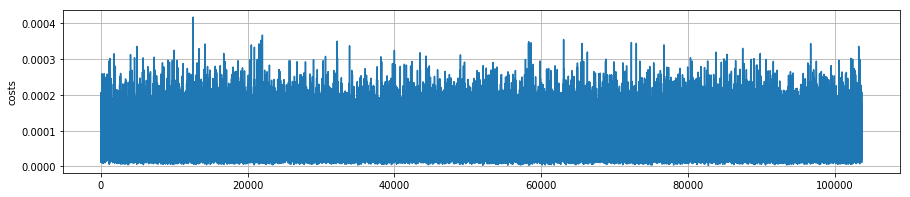


epoch48
Iteration  10371  ( 10.0 %) Train mean loss:  7.823571e-05  ( std:  4.4990407e-05 ) ; run time:  29 [s]
Iteration  20747  ( 20.0 %) Train mean loss:  7.770922e-05  ( std:  4.4721863e-05 ) ; run time:  59 [s]
Iteration  31118  ( 30.0 %) Train mean loss:  7.7694946e-05  ( std:  4.4945005e-05 ) ; run time:  89 [s]
Iteration  41482  ( 40.0 %) Train mean loss:  7.771035e-05  ( std:  4.4921926e-05 ) ; run time:  119 [s]
Iteration  51855  ( 50.0 %) Train mean loss:  7.761859e-05  ( std:  4.480194e-05 ) ; run time:  149 [s]
Iteration  62232  ( 60.0 %) Train mean loss:  7.757304e-05  ( std:  4.477981e-05 ) ; run time:  179 [s]
Iteration  72599  ( 70.0 %) Train mean loss:  7.744692e-05  ( std:  4.462534e-05 ) ; run time:  208 [s]
Iteration  82969  ( 80.0 %) Train mean loss:  7.724849e-05  ( std:  4.456257e-05 ) ; run time:  238 [s]
Iteration  93337  ( 90.0 %) Train mean loss:  7.7165525e-05  ( std:  4.450127e-05 ) ; run time:  267 [s]
Iteration  103708  ( 100.0 %) Train mean loss:  7.70

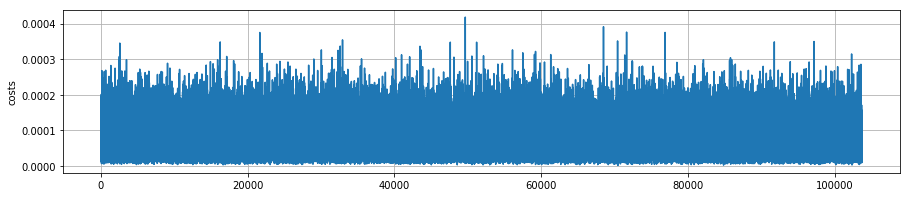


epoch49
Iteration  10374  ( 10.0 %) Train mean loss:  7.5991404e-05  ( std:  4.3774562e-05 ) ; run time:  29 [s]
Iteration  20746  ( 20.0 %) Train mean loss:  7.60827e-05  ( std:  4.423498e-05 ) ; run time:  59 [s]
Iteration  31116  ( 30.0 %) Train mean loss:  7.6039265e-05  ( std:  4.4086046e-05 ) ; run time:  89 [s]
Iteration  41486  ( 40.0 %) Train mean loss:  7.607069e-05  ( std:  4.4023982e-05 ) ; run time:  118 [s]
Iteration  51862  ( 50.0 %) Train mean loss:  7.587529e-05  ( std:  4.3939293e-05 ) ; run time:  148 [s]
Iteration  62236  ( 60.0 %) Train mean loss:  7.580151e-05  ( std:  4.3754066e-05 ) ; run time:  178 [s]
Iteration  72607  ( 70.0 %) Train mean loss:  7.572459e-05  ( std:  4.3732663e-05 ) ; run time:  208 [s]
Iteration  82986  ( 80.0 %) Train mean loss:  7.573214e-05  ( std:  4.3753327e-05 ) ; run time:  237 [s]
Iteration  93363  ( 90.0 %) Train mean loss:  7.560947e-05  ( std:  4.3675383e-05 ) ; run time:  267 [s]
Iteration  103728  ( 100.0 %) Train mean loss:  7

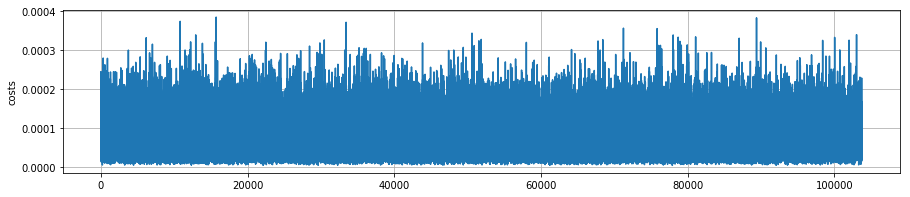


epoch50
Iteration  10370  ( 10.0 %) Train mean loss:  7.4883945e-05  ( std:  4.3027496e-05 ) ; run time:  29 [s]
Iteration  20739  ( 20.0 %) Train mean loss:  7.4671785e-05  ( std:  4.280782e-05 ) ; run time:  59 [s]
Iteration  31116  ( 30.0 %) Train mean loss:  7.468203e-05  ( std:  4.2858774e-05 ) ; run time:  89 [s]
Iteration  41480  ( 40.0 %) Train mean loss:  7.462377e-05  ( std:  4.280471e-05 ) ; run time:  119 [s]
Iteration  51852  ( 50.0 %) Train mean loss:  7.443941e-05  ( std:  4.2728632e-05 ) ; run time:  149 [s]
Iteration  62218  ( 60.0 %) Train mean loss:  7.4412324e-05  ( std:  4.2815438e-05 ) ; run time:  178 [s]
Iteration  72588  ( 70.0 %) Train mean loss:  7.433957e-05  ( std:  4.267923e-05 ) ; run time:  208 [s]
Iteration  82956  ( 80.0 %) Train mean loss:  7.424758e-05  ( std:  4.2692274e-05 ) ; run time:  238 [s]
Iteration  93321  ( 90.0 %) Train mean loss:  7.42541e-05  ( std:  4.2746666e-05 ) ; run time:  268 [s]
Iteration  103711  ( 100.0 %) Train mean loss:  7.

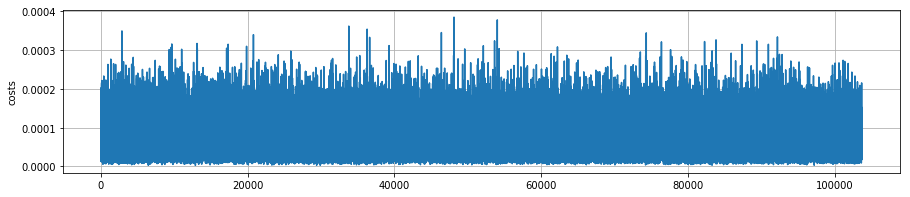


epoch51
Iteration  10362  ( 10.0 %) Train mean loss:  7.3726726e-05  ( std:  4.1822477e-05 ) ; run time:  29 [s]
Iteration  20732  ( 20.0 %) Train mean loss:  7.3565265e-05  ( std:  4.1781826e-05 ) ; run time:  58 [s]
Iteration  31099  ( 30.0 %) Train mean loss:  7.3324496e-05  ( std:  4.1895484e-05 ) ; run time:  88 [s]
Iteration  41462  ( 40.0 %) Train mean loss:  7.318124e-05  ( std:  4.184352e-05 ) ; run time:  117 [s]
Iteration  51827  ( 50.0 %) Train mean loss:  7.2993964e-05  ( std:  4.179119e-05 ) ; run time:  147 [s]
Iteration  62201  ( 60.0 %) Train mean loss:  7.2965326e-05  ( std:  4.181218e-05 ) ; run time:  176 [s]
Iteration  72571  ( 70.0 %) Train mean loss:  7.291098e-05  ( std:  4.1729138e-05 ) ; run time:  206 [s]
Iteration  82948  ( 80.0 %) Train mean loss:  7.288944e-05  ( std:  4.170123e-05 ) ; run time:  235 [s]
Iteration  93315  ( 90.0 %) Train mean loss:  7.27084e-05  ( std:  4.161714e-05 ) ; run time:  265 [s]
Iteration  103694  ( 100.0 %) Train mean loss:  7.

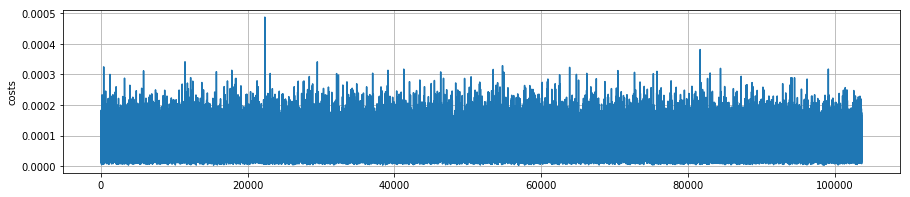


epoch52
Iteration  10378  ( 10.0 %) Train mean loss:  7.158321e-05  ( std:  4.160612e-05 ) ; run time:  29 [s]
Iteration  20754  ( 20.0 %) Train mean loss:  7.180738e-05  ( std:  4.1661013e-05 ) ; run time:  59 [s]
Iteration  31126  ( 30.0 %) Train mean loss:  7.169462e-05  ( std:  4.14738e-05 ) ; run time:  89 [s]
Iteration  41505  ( 40.0 %) Train mean loss:  7.155323e-05  ( std:  4.1484167e-05 ) ; run time:  119 [s]
Iteration  51875  ( 50.0 %) Train mean loss:  7.1331335e-05  ( std:  4.1313626e-05 ) ; run time:  148 [s]
Iteration  62244  ( 60.0 %) Train mean loss:  7.119187e-05  ( std:  4.1259522e-05 ) ; run time:  178 [s]
Iteration  72612  ( 70.0 %) Train mean loss:  7.110893e-05  ( std:  4.1196537e-05 ) ; run time:  207 [s]
Iteration  82985  ( 80.0 %) Train mean loss:  7.112663e-05  ( std:  4.1150906e-05 ) ; run time:  237 [s]
Iteration  93364  ( 90.0 %) Train mean loss:  7.098223e-05  ( std:  4.1030937e-05 ) ; run time:  267 [s]
Iteration  103726  ( 100.0 %) Train mean loss:  7.0

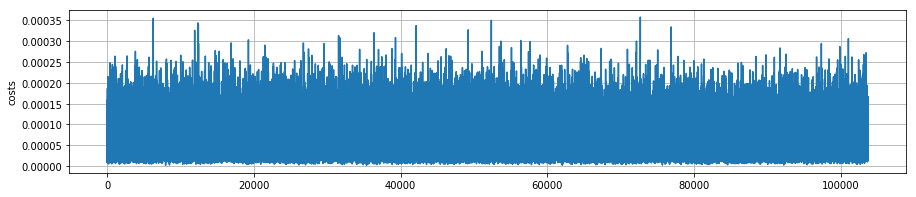


epoch53
Iteration  10369  ( 10.0 %) Train mean loss:  7.11785e-05  ( std:  4.1041738e-05 ) ; run time:  29 [s]
Iteration  20737  ( 20.0 %) Train mean loss:  7.1018534e-05  ( std:  4.090068e-05 ) ; run time:  59 [s]
Iteration  31117  ( 30.0 %) Train mean loss:  7.064753e-05  ( std:  4.0765102e-05 ) ; run time:  89 [s]
Iteration  41490  ( 40.0 %) Train mean loss:  7.055215e-05  ( std:  4.0616356e-05 ) ; run time:  118 [s]
Iteration  51859  ( 50.0 %) Train mean loss:  7.0353584e-05  ( std:  4.0564217e-05 ) ; run time:  148 [s]
Iteration  62229  ( 60.0 %) Train mean loss:  7.034481e-05  ( std:  4.053361e-05 ) ; run time:  178 [s]
Iteration  72600  ( 70.0 %) Train mean loss:  7.025417e-05  ( std:  4.0420244e-05 ) ; run time:  207 [s]
Iteration  82968  ( 80.0 %) Train mean loss:  7.019673e-05  ( std:  4.0401388e-05 ) ; run time:  237 [s]
Iteration  93344  ( 90.0 %) Train mean loss:  7.012591e-05  ( std:  4.0333303e-05 ) ; run time:  267 [s]
Iteration  103714  ( 100.0 %) Train mean loss:  6.

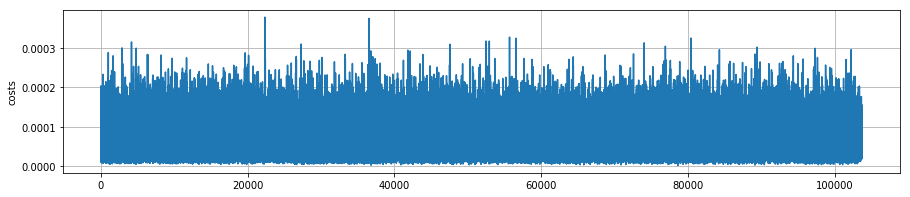


epoch54
Iteration  10370  ( 10.0 %) Train mean loss:  6.956105e-05  ( std:  4.025543e-05 ) ; run time:  29 [s]
Iteration  20733  ( 20.0 %) Train mean loss:  6.905913e-05  ( std:  3.999961e-05 ) ; run time:  59 [s]
Iteration  31097  ( 30.0 %) Train mean loss:  6.895936e-05  ( std:  3.9940758e-05 ) ; run time:  89 [s]
Iteration  41475  ( 40.0 %) Train mean loss:  6.8732945e-05  ( std:  3.9806026e-05 ) ; run time:  118 [s]
Iteration  51843  ( 50.0 %) Train mean loss:  6.870493e-05  ( std:  3.975189e-05 ) ; run time:  148 [s]
Iteration  62215  ( 60.0 %) Train mean loss:  6.867014e-05  ( std:  3.9602095e-05 ) ; run time:  178 [s]
Iteration  72582  ( 70.0 %) Train mean loss:  6.866043e-05  ( std:  3.9617746e-05 ) ; run time:  208 [s]
Iteration  82952  ( 80.0 %) Train mean loss:  6.8710695e-05  ( std:  3.960624e-05 ) ; run time:  237 [s]
Iteration  93328  ( 90.0 %) Train mean loss:  6.86584e-05  ( std:  3.957872e-05 ) ; run time:  267 [s]
Iteration  103697  ( 100.0 %) Train mean loss:  6.855

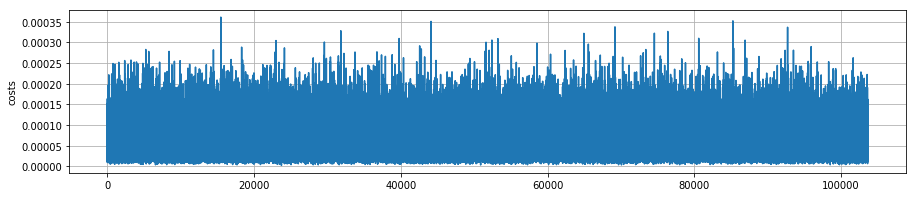


epoch55
Iteration  10360  ( 10.0 %) Train mean loss:  6.724132e-05  ( std:  3.9419556e-05 ) ; run time:  29 [s]
Iteration  20730  ( 20.0 %) Train mean loss:  6.759805e-05  ( std:  3.9191294e-05 ) ; run time:  59 [s]
Iteration  31099  ( 30.0 %) Train mean loss:  6.781518e-05  ( std:  3.9146267e-05 ) ; run time:  89 [s]
Iteration  41471  ( 40.0 %) Train mean loss:  6.767446e-05  ( std:  3.9023344e-05 ) ; run time:  118 [s]
Iteration  51851  ( 50.0 %) Train mean loss:  6.761865e-05  ( std:  3.9013263e-05 ) ; run time:  148 [s]
Iteration  62227  ( 60.0 %) Train mean loss:  6.746447e-05  ( std:  3.8907943e-05 ) ; run time:  178 [s]
Iteration  72590  ( 70.0 %) Train mean loss:  6.739871e-05  ( std:  3.8932823e-05 ) ; run time:  208 [s]
Iteration  82966  ( 80.0 %) Train mean loss:  6.746795e-05  ( std:  3.8933078e-05 ) ; run time:  237 [s]
Iteration  93347  ( 90.0 %) Train mean loss:  6.7430694e-05  ( std:  3.8889106e-05 ) ; run time:  267 [s]
Iteration  103714  ( 100.0 %) Train mean loss:  

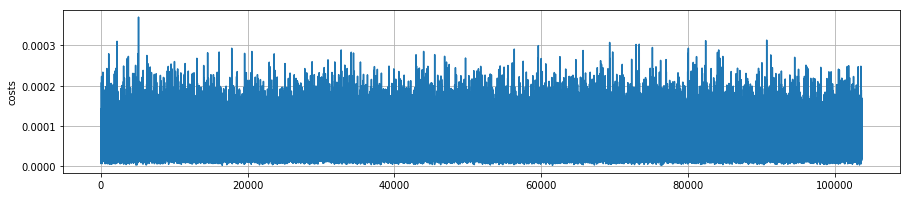


epoch56
Iteration  10362  ( 10.0 %) Train mean loss:  6.683864e-05  ( std:  3.8650855e-05 ) ; run time:  29 [s]
Iteration  20735  ( 20.0 %) Train mean loss:  6.591231e-05  ( std:  3.795887e-05 ) ; run time:  59 [s]
Iteration  31113  ( 30.0 %) Train mean loss:  6.6145985e-05  ( std:  3.8121405e-05 ) ; run time:  89 [s]
Iteration  41497  ( 40.0 %) Train mean loss:  6.6221626e-05  ( std:  3.8132104e-05 ) ; run time:  119 [s]
Iteration  51864  ( 50.0 %) Train mean loss:  6.622223e-05  ( std:  3.8089034e-05 ) ; run time:  148 [s]
Iteration  62238  ( 60.0 %) Train mean loss:  6.620147e-05  ( std:  3.806118e-05 ) ; run time:  178 [s]
Iteration  72609  ( 70.0 %) Train mean loss:  6.617522e-05  ( std:  3.80884e-05 ) ; run time:  208 [s]
Iteration  82967  ( 80.0 %) Train mean loss:  6.618976e-05  ( std:  3.8069888e-05 ) ; run time:  238 [s]
Iteration  93334  ( 90.0 %) Train mean loss:  6.610983e-05  ( std:  3.8021783e-05 ) ; run time:  267 [s]
Iteration  103713  ( 100.0 %) Train mean loss:  6.6

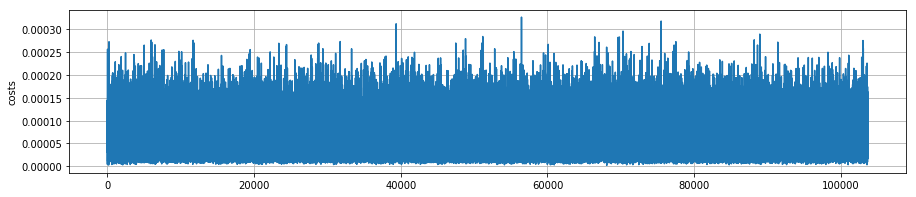


epoch57
Iteration  10380  ( 10.0 %) Train mean loss:  6.545091e-05  ( std:  3.7258644e-05 ) ; run time:  29 [s]
Iteration  20744  ( 20.0 %) Train mean loss:  6.542066e-05  ( std:  3.750174e-05 ) ; run time:  59 [s]
Iteration  31111  ( 30.0 %) Train mean loss:  6.541196e-05  ( std:  3.749223e-05 ) ; run time:  89 [s]
Iteration  41479  ( 40.0 %) Train mean loss:  6.5332715e-05  ( std:  3.7498245e-05 ) ; run time:  118 [s]
Iteration  51860  ( 50.0 %) Train mean loss:  6.51508e-05  ( std:  3.7330505e-05 ) ; run time:  148 [s]
Iteration  62229  ( 60.0 %) Train mean loss:  6.5127104e-05  ( std:  3.7341066e-05 ) ; run time:  178 [s]
Iteration  72600  ( 70.0 %) Train mean loss:  6.500919e-05  ( std:  3.723738e-05 ) ; run time:  207 [s]
Iteration  82976  ( 80.0 %) Train mean loss:  6.4947584e-05  ( std:  3.7271602e-05 ) ; run time:  237 [s]
Iteration  93343  ( 90.0 %) Train mean loss:  6.4903754e-05  ( std:  3.7193386e-05 ) ; run time:  267 [s]
Iteration  103708  ( 100.0 %) Train mean loss:  6

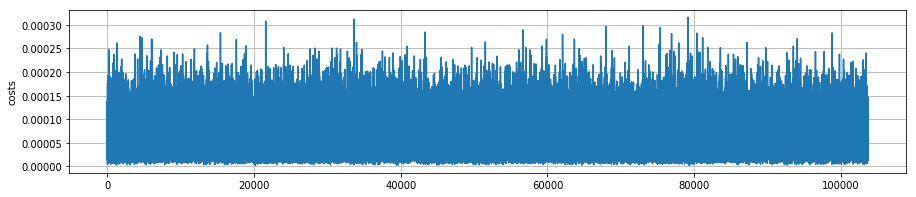


epoch58
Iteration  10369  ( 10.0 %) Train mean loss:  6.4111875e-05  ( std:  3.6777907e-05 ) ; run time:  29 [s]
Iteration  20749  ( 20.0 %) Train mean loss:  6.431355e-05  ( std:  3.6839472e-05 ) ; run time:  59 [s]
Iteration  31125  ( 30.0 %) Train mean loss:  6.425605e-05  ( std:  3.701815e-05 ) ; run time:  89 [s]
Iteration  41493  ( 40.0 %) Train mean loss:  6.417478e-05  ( std:  3.692731e-05 ) ; run time:  118 [s]
Iteration  51861  ( 50.0 %) Train mean loss:  6.409196e-05  ( std:  3.682089e-05 ) ; run time:  148 [s]
Iteration  62231  ( 60.0 %) Train mean loss:  6.409575e-05  ( std:  3.687329e-05 ) ; run time:  178 [s]
Iteration  72599  ( 70.0 %) Train mean loss:  6.402564e-05  ( std:  3.686366e-05 ) ; run time:  208 [s]
Iteration  82964  ( 80.0 %) Train mean loss:  6.391675e-05  ( std:  3.681656e-05 ) ; run time:  237 [s]
Iteration  93336  ( 90.0 %) Train mean loss:  6.3855914e-05  ( std:  3.6774258e-05 ) ; run time:  267 [s]
Iteration  103700  ( 100.0 %) Train mean loss:  6.380

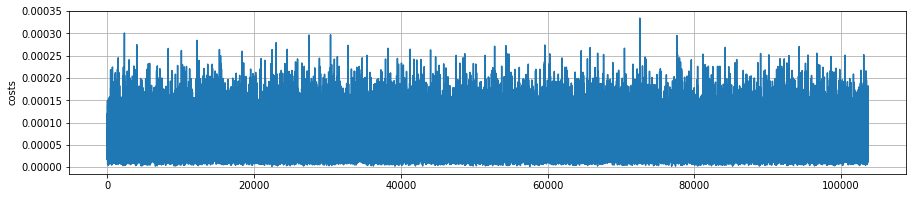


epoch59
Iteration  10372  ( 10.0 %) Train mean loss:  6.287144e-05  ( std:  3.6712358e-05 ) ; run time:  29 [s]
Iteration  20744  ( 20.0 %) Train mean loss:  6.278598e-05  ( std:  3.6265603e-05 ) ; run time:  58 [s]
Iteration  31116  ( 30.0 %) Train mean loss:  6.2965126e-05  ( std:  3.6234633e-05 ) ; run time:  88 [s]
Iteration  41488  ( 40.0 %) Train mean loss:  6.2907275e-05  ( std:  3.6115896e-05 ) ; run time:  117 [s]
Iteration  51855  ( 50.0 %) Train mean loss:  6.285801e-05  ( std:  3.604687e-05 ) ; run time:  147 [s]
Iteration  62231  ( 60.0 %) Train mean loss:  6.284373e-05  ( std:  3.6090325e-05 ) ; run time:  177 [s]
Iteration  72602  ( 70.0 %) Train mean loss:  6.279938e-05  ( std:  3.603785e-05 ) ; run time:  206 [s]
Iteration  82972  ( 80.0 %) Train mean loss:  6.281686e-05  ( std:  3.6018868e-05 ) ; run time:  236 [s]
Iteration  93344  ( 90.0 %) Train mean loss:  6.2799525e-05  ( std:  3.6000598e-05 ) ; run time:  265 [s]
Iteration  103709  ( 100.0 %) Train mean loss:  

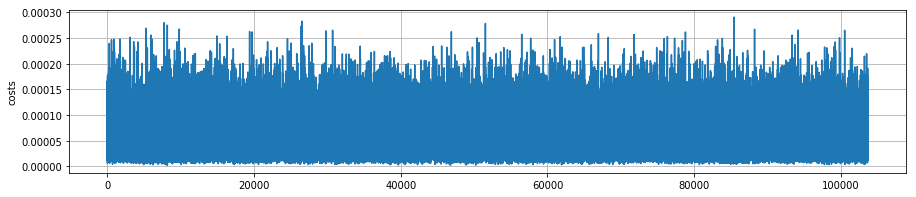


epoch60
Iteration  10376  ( 10.0 %) Train mean loss:  6.265345e-05  ( std:  3.5851495e-05 ) ; run time:  29 [s]
Iteration  20742  ( 20.0 %) Train mean loss:  6.208708e-05  ( std:  3.576011e-05 ) ; run time:  58 [s]
Iteration  31117  ( 30.0 %) Train mean loss:  6.2222985e-05  ( std:  3.582118e-05 ) ; run time:  88 [s]
Iteration  41482  ( 40.0 %) Train mean loss:  6.219181e-05  ( std:  3.5825593e-05 ) ; run time:  117 [s]
Iteration  51857  ( 50.0 %) Train mean loss:  6.201096e-05  ( std:  3.568076e-05 ) ; run time:  147 [s]
Iteration  62216  ( 60.0 %) Train mean loss:  6.198672e-05  ( std:  3.5665882e-05 ) ; run time:  176 [s]
Iteration  72593  ( 70.0 %) Train mean loss:  6.1907485e-05  ( std:  3.5582492e-05 ) ; run time:  206 [s]
Iteration  82965  ( 80.0 %) Train mean loss:  6.1901934e-05  ( std:  3.5566034e-05 ) ; run time:  236 [s]
Iteration  93339  ( 90.0 %) Train mean loss:  6.184821e-05  ( std:  3.556775e-05 ) ; run time:  265 [s]
Iteration  103710  ( 100.0 %) Train mean loss:  6.

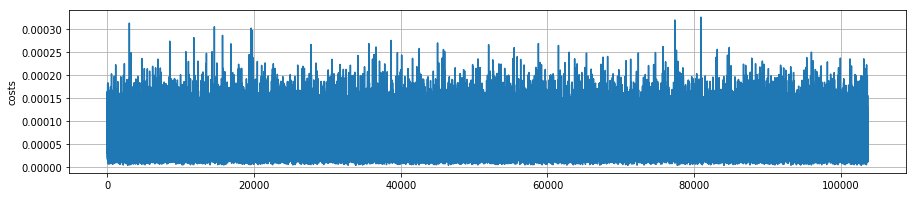


Elapsed time in total: 17981


In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
################################################################
# Set parameter
################################################################
build_new_model = True

patience = 0
num_epoch = 60
batch_size = 128
embedding_size = 300 # Dimension of the embedding vector.
w2v_lr = 1.0
exp_decay_rate = 0.8
vocab_size = len(vocab)
num_instances = sum_content_size
iter_per_epoch = num_instances // batch_size

exp_decay_steps = sum_content_size // batch_size
similar_nn_num = 10 # number of nearest neighbors

valid_examples = [vocab[SOS_id],vocab['我'],vocab['台灣'],vocab['工作'],
                   vocab['喜歡'],vocab['可以'],vocab['約'],vocab['電影'],
                   vocab['時間'],vocab['滿足'],vocab['閃光'],vocab[EOS_id]]
number_sampled = 10 # Number of negative examples to sample.

################################################################
# Load Embedding model
################################################################
def load_embed():
    embed_epoch = 60
    embed_name = 'PTT_Words_Embedding_1526955724.200002'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    embed_dir = os.path.join(mdl_dir, embed_name)
    if not os.path.exists(embed_dir):
        os.makedirs(embed_dir)
    
    word2vector_graph = tf.Graph()
    with tf.Session(graph=word2vector_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_embed_dir = os.path.join(embed_dir, 'model-{}'.format(embed_epoch))
        loader = tf.train.import_meta_graph(load_embed_dir + '.meta')
        loader.restore(sess, load_embed_dir)
        # Load named input parameters
        embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
        print('Embeddings lookup shape: ', embeddings.shape)
        norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
        normal_embeddings = embeddings / norm
    return embeddings, normal_embeddings

################################################################
# Build Vector2word model
################################################################
def word2vector_model():
    train_inputs = tf.placeholder(tf.int32, shape=[None], name='train_inputs')
    train_labels = tf.placeholder(tf.int32, shape=[None, 1], name='train_labels')
    
    # Look up embeddings for inputs.
    embeddings = tf.constant(load_embed()[0])
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # Construct the variables for the softmax
    v2w_weights = tf.Variable(tf.truncated_normal([vocab_size+1, embedding_size],
                                                  stddev=1.0 / np.sqrt(embedding_size)), 
                              name='v2w_weights')
    v2w_biases = tf.Variable(tf.zeros([vocab_size+1]),
                           name='v2w_biases')
    
    # Compute the NCE loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=v2w_weights,
                                                     biases=v2w_biases,
                                                     labels=train_labels,
                                                     inputs=embed,
                                                     num_sampled=number_sampled,
                                                     num_classes=vocab_size+1),
                         name='nce_cost')
    # We use the SGD optimizer.
    global_step = tf.Variable(0, trainable=False)
    dynam_w2v_lr = tf.train.exponential_decay(w2v_lr, global_step, exp_decay_steps, 
                                                           exp_decay_rate, staircase=False)
    global_step = global_step + 1
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=dynam_w2v_lr).minimize(loss, 
                                                name='optimizer')
    return train_inputs, train_labels, loss, optimizer, embeddings
    
################################################################
# Prepare to run session
################################################################
total_start_t = time.time()
if build_new_model:
    str_epoch = 0
    model_name = 'PTT_vector2word_' + str(total_start_t)
else:
    str_epoch = 50
    model_name = 'PTT_vector2word_1523412734.9787965'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    model_dir = os.path.join(mdl_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

iter_pct = num_instances // 10
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1
costs_list = []

best_costs_mean = 0.0
early_stop_counter = 0

################################################################
# Run model session
################################################################
word2vector_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with word2vector_graph.as_default():
        train_inputs, train_labels, cost, optimizer, embeddings = word2vector_model()

with tf.Session(graph=word2vector_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        train_inputs = word2vector_graph.get_tensor_by_name('train_inputs:0')
        train_labels = word2vector_graph.get_tensor_by_name('train_labels:0')
        loss = word2vector_graph.get_tensor_by_name('nce_cost')
        optimizer = word2vector_graph.get_operation_by_name('optimizer')
        
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        costs = []
        
        ######## Get random input batch and training model. ########
        batch_counts = 0
        iter_count = 0
        X_batch = []
        for i in range(num_instances):
            rand_input = total_inputs[rand_idxs[i]]
            vocab_rand = np.random.uniform(0.0, 1.0)
            if vocab_rand < vocab_rate[rand_input]:
                #if 0 in rand_label:
                    #np.delete(rand_label, np.argwhere(0 == rand_label))
                X_batch.append(rand_input)
                batch_counts = (batch_counts + 1) % batch_size
                
                if batch_counts % batch_size == 0:
                    iter_count += 1
                    X_batch = np.array(X_batch)
                    Y_batch = np.array(X_batch).reshape((-1,1))
                    optimizer_op, loss = sess.run( [optimizer, cost],
                                        {train_inputs: X_batch, train_labels: Y_batch})
                    X_batch = []
                    Y_batch = []
                    if np.isnan(loss):
                        print('\n!!!! Loss is NaN! !!!!')
                        print('NaN epoch: ', e, ' ; NaN iteration: ', iter_count)
                        print('The last loss: ', last_loss)
                        print('Optimizer: ', optimizer_op)
                        print('The last optimizer: ', last_optimizer_op)
                        break
                    else:
                        costs.append(loss)
                        last_loss = loss
                        last_optimizer_op = optimizer_op
            
            if (i+1) % iter_pct == 0:
                costs_pct10 = np.array(costs[-iter_pct:])
                print('Iteration ',iter_count,' (',round((i+1)*100/num_instances,2),'%) Train mean loss: ',
                      costs_pct10.mean(), ' ( std: ', costs_pct10.std(), 
                      ') ; run time: ', int(time.time() - start_t), '[s]')
            '''elif i == 0:
                print('Iteration ',iter_count,' (',round((i+1)*100/num_instances,2),'%) Train mean loss: ',
                      loss, '; run time: ', int(time.time() - start_t), '[s]')'''
        
        ######## Save model weight parameters and information. ########
        costs_mean = np.array(costs).mean()
        if costs_mean < best_costs_mean or e == 0:
            best_costs_mean = costs_mean
            best_epoch = e
            early_stop_counter = 0
            print('Save best score!! ', best_costs_mean)
        else:
            early_stop_counter += 1
            print('Count early stop!! ', early_stop_counter)

        print('Elapsed time in epoch ', e+1, ': ', int(time.time() - start_t), 
              ' [s]: iteration number: ', iter_count)
        
        if e==0:
            mdl_dir = os.path.join(base_dir, 'model')
            if not os.path.exists(mdl_dir):
                os.makedirs(mdl_dir)
            model_dir = os.path.join(mdl_dir, model_name)
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        ######## Print cost curve of this epoch. ########
        costs_list.append(costs)
        plt.figure(figsize=(15,3))
        plt.plot(costs)
        plt.ylabel('costs')
        plt.grid()
        plt.show()
        
        ######## Generate title form testing content and validating model. ########
        
        if patience != 0 and early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best score: ', best_costs_mean, 'Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(int(time.time() - total_start_t)))